In [ ]:
!pip install nibabel
!pip install medicaltorch
# !pip install visdom

In [ ]:
#@title [Please run] Custom transformations 
import numpy as np
import numbers
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torchvision.transforms.functional

class MTTransform(object):

    def __call__(self, sample):
        raise NotImplementedError("You need to implement the transform() method.")

    def undo_transform(self, sample):
        raise NotImplementedError("You need to implement the undo_transform() method.")


class UndoCompose(object):
    def __init__(self, compose):
        self.transforms = compose.transforms

    def __call__(self):
        for t in self.transforms:
            img = t.undo_transform(img)
        return img


class UndoTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        return self.transform.undo_transform(sample)


class ToTensor(MTTransform):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [F.to_tensor(item)
                         for item in input_data]
        else:
            ret_input = F.to_tensor(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                if isinstance(gt_data, list):
                    ret_gt = [F.to_tensor(item)
                              for item in gt_data]
                else:
                    ret_gt = F.to_tensor(gt_data)

                rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class ToPIL(MTTransform):
    def __init__(self, labeled=True):
        self.labeled = labeled

    def sample_transform(self, sample_data):
        # Numpy array
        if not isinstance(sample_data, np.ndarray):
            input_data_npy = sample_data.numpy()
        else:
            input_data_npy = sample_data

        input_data_npy = np.transpose(input_data_npy, (1, 2, 0))
        input_data_npy = np.squeeze(input_data_npy, axis=2)
        input_data = Image.fromarray(input_data_npy, mode='F')
        return input_data

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [self.sample_transform(item)
                         for item in input_data]
        else:
            ret_input = self.sample_transform(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']

            if isinstance(gt_data, list):
                ret_gt = [self.sample_transform(item)
                          for item in gt_data]
            else:
                ret_gt = self.sample_transform(gt_data)

            rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class res(MTTransform):
    """Make a center crop of a specified size.

    :param segmentation: if it is a segmentation task.
                         When this is True (default), the crop
                         will also be applied to the ground truth.
    """
    def __init__(self, size, labeled=True):
        self.size = size
        self.labeled = labeled

    @staticmethod
    def propagate_params(sample, params):
        input_metadata = sample['input_metadata']
        input_metadata["__centercrop"] = params
        return input_metadata

    @staticmethod
    def get_params(sample):
        input_metadata = sample['input_metadata']
        return input_metadata["__centercrop"]

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        w, h = input_data.size
        th, tw = self.size
        fh = int(round((h - th) / 2.))
        fw = int(round((w - tw) / 2.))

        params = (fh, fw, w, h)
        self.propagate_params(sample, params)

        input_data = torchvision.transforms.functional.resize(input_data, self.size)
        rdict['input'] = input_data

        if self.labeled:
            gt_data = sample['gt']
            gt_metadata = sample['gt_metadata']
            gt_data = torchvision.transforms.functional.resize(gt_data, self.size)
            gt_metadata["__centercrop"] = (fh, fw, w, h)
            rdict['gt'] = gt_data


        sample.update(rdict)
        return sample

    def undo_transform(self, sample):
        rdict = {}
        input_data = sample['input']
        fh, fw, w, h = self.get_params(sample)
        th, tw = self.size

        pad_left = fw
        pad_right = w - pad_left - tw
        pad_top = fh
        pad_bottom = h - pad_top - th

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        input_data = F.pad(input_data, padding)
        rdict['input'] = input_data

        sample.update(rdict)
        return sample







In [ ]:
# for custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import glob
import nibabel as nib
import os
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
import math
from torch.utils.data import DataLoader

In [ ]:
drive.mount('/gdrive')
ROOT_DIR = "/gdrive/My Drive/MM-WHS 2017 Dataset/"
# ROOT_DIR = 'drive/MyDrive/MM-WHS 2017 Dataset/'
mri_input_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_label.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(159)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# print(input_slice.shape)
# img = input_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()
# img = gt_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()

# img_data,seg_data = pair.get_pair_data()
# img_data.shape
# seg_data.shape

In [ ]:

img_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz"))
label_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz"))

In [ ]:
filename_pairs = [(os.path.join(ROOT_DIR,'mr_train',x),os.path.join(ROOT_DIR,'mr_train',y)) for x,y in zip(img_list,label_list)]

img_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*image.nii.gz"))
label_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*label.nii.gz"))

filename_pairs2 = [(os.path.join(ROOT_DIR,'ct_train',x),os.path.join(ROOT_DIR,'ct_train',y)) for x,y in zip(img_list2,label_list2)]

In [ ]:
from torchvision import transforms, utils
from skimage import io, transform

'''
Subset data to ony get 1 sample out
'''
dat=filename_pairs[0]
lbl=filename_pairs2[0]

filename_pairs.clear()
filename_pairs2.clear()

filename_pairs.append(dat)
filename_pairs2.append(lbl)

print(filename_pairs)

# print(type(filename_pairs[0]))
# print(len(filename_pairs2[0]))


train_transform = transforms.Compose([

        # transforms.Resize((256,256)),
        # transforms.ToPILImage(),
        # transforms.ToTensor()
        res((65,65)),
        mt_transforms.ToTensor()
        
        ]
)

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)
train_dataset2= mt_datasets.MRI2DSegmentationDataset(filename_pairs2,transform=train_transform)


[('/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_image.nii.gz', '/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_label.nii.gz')]


In [ ]:

dataloader = DataLoader(train_dataset, batch_size=1,collate_fn=mt_datasets.mt_collate)
dataloader2= DataLoader(train_dataset2, batch_size=1, collate_fn=mt_datasets.mt_collate)

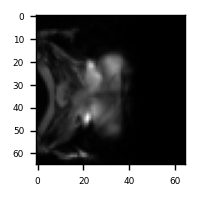

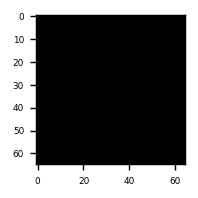

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 5})
for _ in range(1):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
      
        '''
        CT IMAGE
        '''
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        '''
        CT seg mask
        '''

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()


        '''
        MRI image
        '''

        # plt.figure(figsize = (1.5,1.5), dpi=128)
        # plt.imshow(batch[1]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.tight_layout()
        # plt.show()

        break
'''
visualize images
'''
def vis(image):
    plt.imshow(image[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
    plt.show()

In [ ]:
# https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/21
# https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/random_ops.py#L163

def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
      cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
      if not torch.sum(cond):
        break
      t = torch.where(cond.cuda(), torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std).cuda(), t.cuda()).cuda()
      
    # return t

def compute_conv_output(H, K, S):
  return int(((H-K+2*0)/S)+1)

def compute_padding(out, H, K, S):
  return int((S*(out-1)-H+K)/2)

def compute_padding_deconv(out, H, K, S):
  return int((-out+(H-1)*S+K)/2)

def compute_maxpool_padding(S, H, f):
  '''
  H2=(H1-f)/s+1
  '''
  return int((S*(H-1)-H+f)/2)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:

class General_Conv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.01)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.01, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          # if train:
            # self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          # else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          # if train:
            # self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          # else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))

    def forward(self, x):

        '''
        initialize weights
        '''
        
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif (self.norm_type=='Ins'):
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
        

        return x

        # return x + self.block(x)


class Resnet_Block(nn.Module):
    def __init__(self, in_features, out_features , padding="REFLECT", norm_type=None, keep_rate=0.75):
        super(Resnet_Block, self).__init__()

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.ModuleList([
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        ])

      
        self.relu=nn.ReLU()

    def forward(self, x):      

        for i in range(len(self.block)):
          if i==0:
            out = self.block[i](x)
          else:
            out = self.block[i](out)

  
        return self.relu(out+x)

class Resnet_Block_ds(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ds, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.ModuleList([
            
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(out_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        ])

        self.relu = nn.ReLU()

    def forward(self, x):
     
        for i in range(len(self.block)):
          if i==0:
            out = self.block[i](x)
          else:
            out = self.block[i](out)
        '''
        pad channel dim
        '''
        pd=(self.out_features-self.in_features) // 2

        padding = torch.zeros(x.shape[0], pd, x.shape[2], x.shape[3]).cuda()
        padded_inp = torch.cat((x, padding), 1)
        padded_inp = torch.cat((padding, padded_inp), 1)


        return self.relu(out+padded_inp)
  
class drn_Block(nn.Module):
    def __init__(self, in_features, keep_rate=0.75):
        super(drn_Block, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
        )

        self.relu=nn.ReLU()

    def forward(self, x):
        x = x + self.block(x)
        

        return self.relu(x)



class General_Conv2D_GA(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D_GA, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''
     
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        # if not self.keep_rate is None:
        #   x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif self.norm_type=='Ins':# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
       

        return x


class Resnet_Block_ins(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None):
        super(Resnet_Block_ins, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.ModuleList([
            
            pad_layer,
            General_Conv2D_GA(in_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=True),
            pad_layer,
            General_Conv2D_GA(out_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=False)

            ]
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)
      # out=out.add(y)
      return self.relu(out+y)
      # return self.relu(torch.cat((out,y)))

      # for i in range(len(self.block)):
      #     x=self.block[i](x)
      
      # return self.relu(torch.cat((x,y)))
class General_Deconv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0, out_shape=0):
        super(General_Deconv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.out_shape=out_shape
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(in_features, out_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        if self.padding==False:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=0)
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=compute_padding_deconv(self.out_shape, x.shape[-1], self.k, self.s))
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)


        'explicit resize'
        # x=x[:,:,:self.out_shape,:self.out_shape]
        

        return x


  

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, skip=True):
        super(GeneratorResNet, self).__init__()

        self.skip=skip
        # self.input_img=input_img
        self.max_features = 32*2 # used to be 32*4 but there were memory issues.
        
        self.block = nn.ModuleList([
            nn.ZeroPad2d(3),
            General_Conv2D_GA(in_features=1, out_features=32, k=7, s=1, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=False),
            General_Conv2D_GA(in_features=32, out_features=32*2, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            General_Conv2D_GA(in_features=32*2, out_features=self.max_features, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            General_Deconv2D(in_features=self.max_features, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
            General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
            General_Conv2D_GA(in_features=32, out_features=1, k=7, s=1, stddev=0.02, do_relu=False, train=True, padding=True),
            ]
            )
        self.tanh = torch.nn.Tanh()
        self.pad = torch.nn.ReflectionPad2d((1,0,1,0))
        
        

    def forward(self, x):

      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)

      y=self.pad(y)
      if self.skip==True:
        return self.tanh(out+y)
      else:
        return self.tanh(out)

    

In [ ]:
'''
input shape: B,C,H,W
'''
class EncoderNet(nn.Module):
    def __init__(self, input_shape):
        super(EncoderNet, self).__init__()
        
        self.input_shape=input_shape

  

        self.out_c1 = General_Conv2D(in_features=1, out_features=16, padding=True, input_dim=self.input_shape[-1], norm_type='Batch')
        self.out_res1 = Resnet_Block(in_features=16,out_features=16,norm_type='Batch')
        self.out1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))
        
        self.out_res2 = Resnet_Block_ds(in_features=16, out_features=16*2, norm_type='Batch', padding='CONSTANT')

        self.out_res3 = Resnet_Block_ds(in_features=16*2, out_features=16*4, norm_type='Batch', padding='CONSTANT')
        self.out_res4 = Resnet_Block(in_features=16*4,out_features=16*4,norm_type='Batch', padding='CONSTANT')

        self.out_res5 = Resnet_Block_ds(in_features=16*4,out_features=16*8,norm_type='Batch', padding='CONSTANT')
        self.out_res6 = Resnet_Block(in_features=16*8,out_features=16*8,norm_type='Batch', padding='CONSTANT')

        self.out_res7 = Resnet_Block_ds(in_features=16*8,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res8 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res9 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res10= Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res11= Resnet_Block_ds(in_features=16*16,out_features=16*32,norm_type='Batch', padding='CONSTANT')
        self.out_res12= Resnet_Block(in_features=16*32,out_features=16*32,norm_type='Batch', padding='CONSTANT')

        self.out_drn1 = drn_Block(in_features=16*32)
        self.out_drn2 = drn_Block(in_features=16*32)
        
        self.out_c2 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, input_dim=0, norm_type='Batch')
        self.out_c3 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, input_dim=0, norm_type='Batch')


    def forward(self, x):
  
        '''
        separate kernel size implementation from tf not available in pytorch
        TODO
        '''
        x=self.out_c1(x)
        x=self.out_res1(x)
        x=self.out1(x)
        x=self.out_res2(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # x=self.out2(x)
        x=self.out_res3(x)
        x=self.out_res4(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # x=self.out3(x)
        x=self.out_res5(x)
        x=self.out_res6(x)
        x=self.out_res7(x)
        x=self.out_res8(x)
        x=self.out_res9(x)
        x=self.out_res10(x)
       
        x=self.out_res11(x)
        x=self.out_res12(x)
        y=x
        x=self.out_drn1(x)
        x=self.out_drn2(x)
        '''
        '''
        x=self.out_c2(x)
        x=self.out_c3(x)

        return x, y

In [ ]:
class DecoderNet(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(DecoderNet, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape
        
        self.block = nn.ModuleList([
          General_Conv2D(in_features=self.input_shape[1], k=3, s=1, out_features=32*4, padding=True, input_dim=self.input_shape[-1], norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4, padding='CONSTANT', norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins'),
          General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=16, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
          General_Conv2D(in_features=32, out_features=1, k=7, s=1, norm_type=None, do_relu=False, stddev=0.02, padding=True, input_dim=self.input_shape[-1])
        ])

        self.tanh = nn.Tanh()

    def forward(self, x, input_img):
      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)

      if self.skip==True:
        return self.tanh(input_img+out)
      else:
        return self.tanh(out)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(Discriminator, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape

        self.block = nn.ModuleList([
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=1, out_features=64, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        ]
        )

    def forward(self, x):
      for i in range(len(self.block)):
          x=self.block[i](x)
      return x


In [ ]:
class Discriminator_aux(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(Discriminator_aux, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape

        self.block = nn.ModuleList([
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=1, out_features=64, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        ])

    def forward(self, x):
      for i in range(len(self.block)):
          x=self.block[i](x)
      # return out, out
      return torch.unsqueeze(x[...,0], dim=3), torch.unsqueeze(x[...,1], dim=3) 

In [ ]:
'''
Params for cycle loss calculation
'''
LAMBDA_A=10
LAMBDA_B=10

In [ ]:
'''
Losses
'''

'''
Copute lsgan loss for generator
'''
def lsgan_loss_generator(prob_fake_is_real):
    return (torch.mean((prob_fake_is_real - 1)**2))

'''
Compute lsgan loss (which needs to be minimized) (lsgan to help with vanishing/exploding gradients)?
'''
def lsgan_loss_discriminator(prob_real_is_real, prob_fake_is_real):
    return (torch.mean((prob_real_is_real - 1)**2) + torch.mean((prob_fake_is_real - 0)**2))*0.5


'''
Compute cycle loss
'''
def cycle_consistency_loss(real_images, generated_images):
    return (torch.mean(torch.abs(real_images - generated_images)))


[Epoch 0/20000] [G_A loss: 6.874118] [D_B loss: 2.470082]

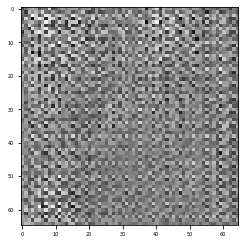

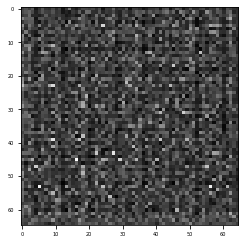

[Epoch 1/20000] [G_A loss: 188.102234] [D_B loss: 3.036725]

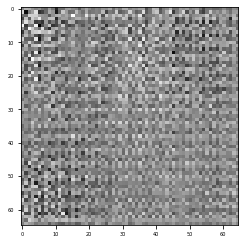

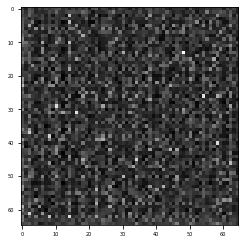

[Epoch 2/20000] [G_A loss: 13.934769] [D_B loss: 0.899691]

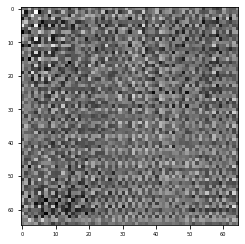

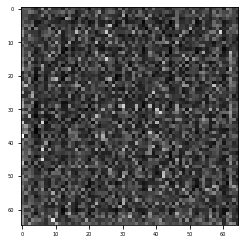

[Epoch 3/20000] [G_A loss: 6.677611] [D_B loss: 0.604748]

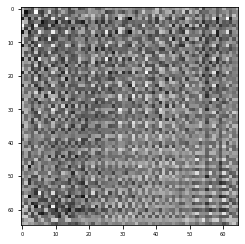

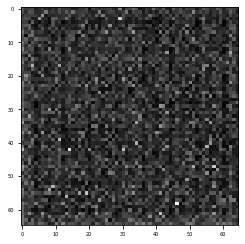

[Epoch 4/20000] [G_A loss: 5.821812] [D_B loss: 0.428244]

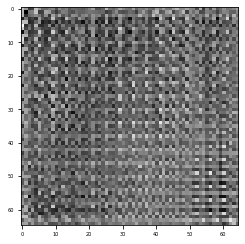

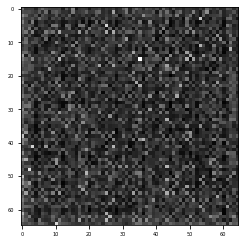

[Epoch 5/20000] [G_A loss: 4.484002] [D_B loss: 0.419770]

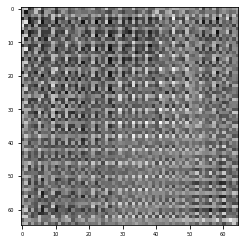

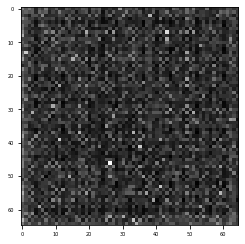

[Epoch 6/20000] [G_A loss: 4.848215] [D_B loss: 0.335227]

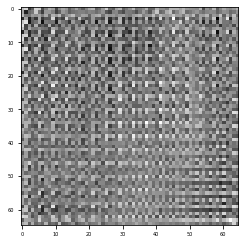

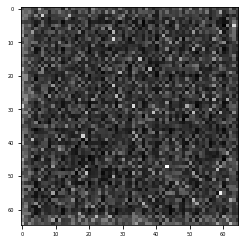

[Epoch 7/20000] [G_A loss: 5.225038] [D_B loss: 0.243126]

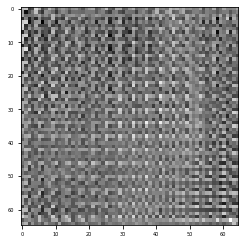

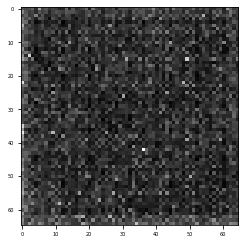

[Epoch 8/20000] [G_A loss: 4.670110] [D_B loss: 0.222569]

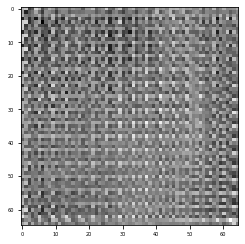

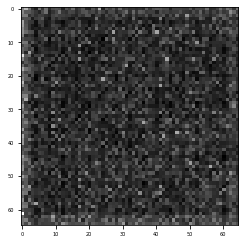

[Epoch 9/20000] [G_A loss: 4.331723] [D_B loss: 0.199431]

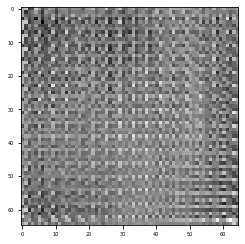

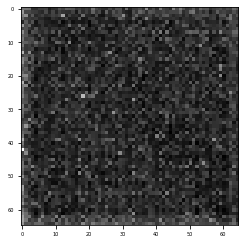

[Epoch 10/20000] [G_A loss: 4.283640] [D_B loss: 0.192517]

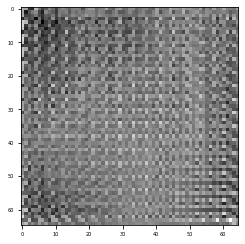

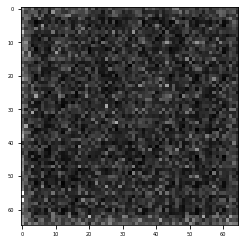

[Epoch 11/20000] [G_A loss: 4.372254] [D_B loss: 0.206049]

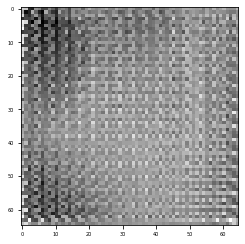

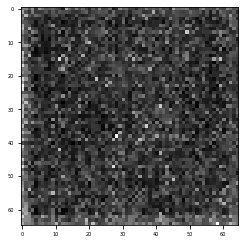

[Epoch 12/20000] [G_A loss: 4.473545] [D_B loss: 0.219911]

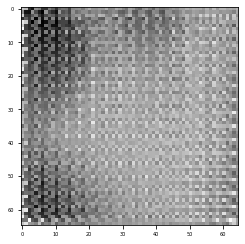

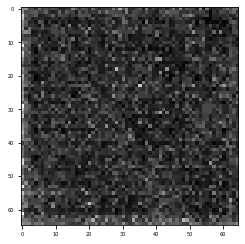

[Epoch 13/20000] [G_A loss: 4.462823] [D_B loss: 0.253307]

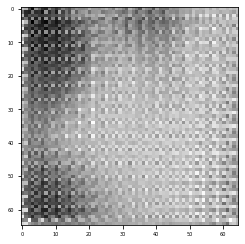

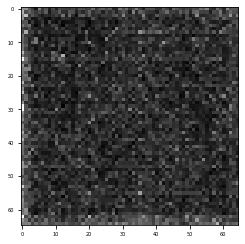

[Epoch 14/20000] [G_A loss: 4.406390] [D_B loss: 0.325875]

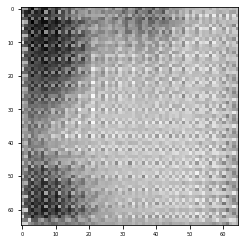

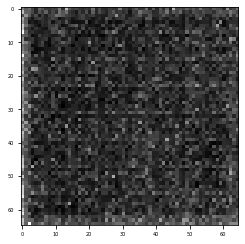

[Epoch 15/20000] [G_A loss: 4.348068] [D_B loss: 0.429638]

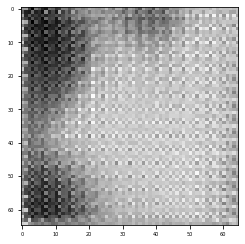

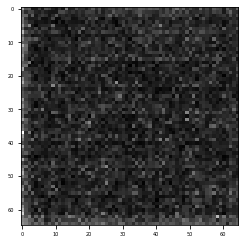

[Epoch 16/20000] [G_A loss: 4.346456] [D_B loss: 0.473603]

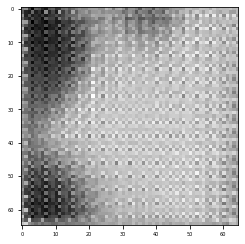

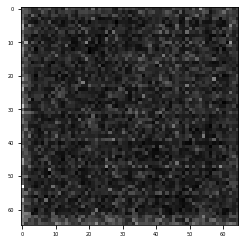

[Epoch 17/20000] [G_A loss: 4.358466] [D_B loss: 0.388477]

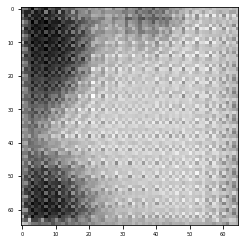

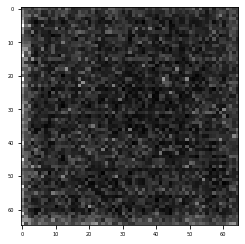

[Epoch 18/20000] [G_A loss: 4.375973] [D_B loss: 0.281745]

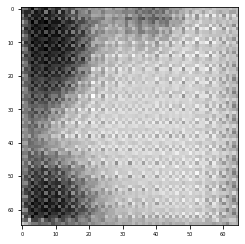

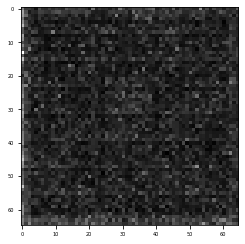

[Epoch 19/20000] [G_A loss: 4.337915] [D_B loss: 0.261666]

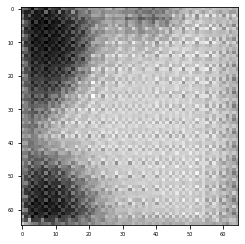

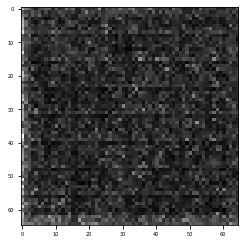

[Epoch 20/20000] [G_A loss: 4.331931] [D_B loss: 0.257329]

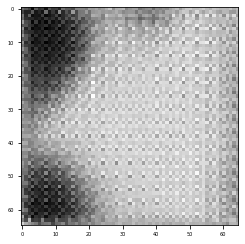

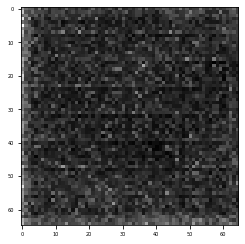

[Epoch 21/20000] [G_A loss: 4.309159] [D_B loss: 0.250414]

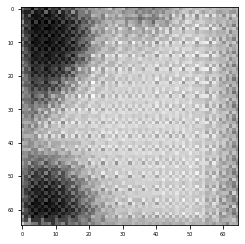

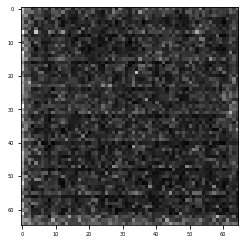

[Epoch 22/20000] [G_A loss: 4.338923] [D_B loss: 0.248968]

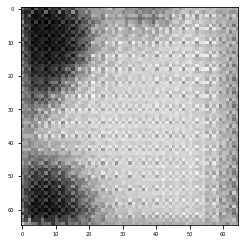

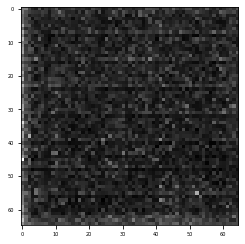

[Epoch 23/20000] [G_A loss: 4.331798] [D_B loss: 0.248585]

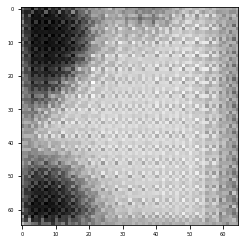

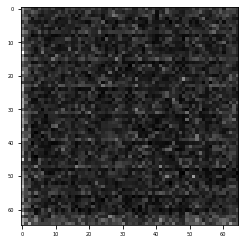

[Epoch 24/20000] [G_A loss: 4.333627] [D_B loss: 0.243851]

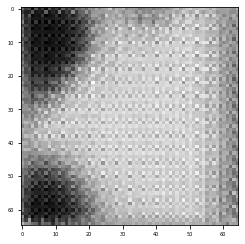

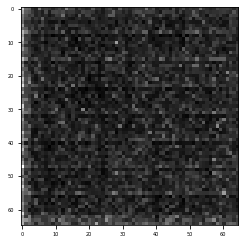

[Epoch 25/20000] [G_A loss: 4.303375] [D_B loss: 0.239920]

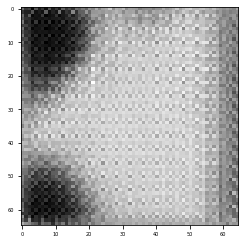

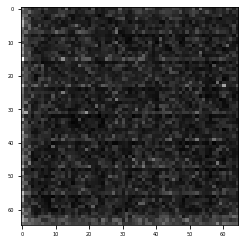

[Epoch 26/20000] [G_A loss: 4.299402] [D_B loss: 0.236737]

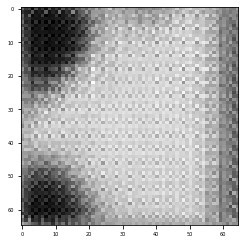

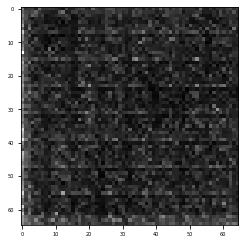

[Epoch 27/20000] [G_A loss: 4.317380] [D_B loss: 0.239081]

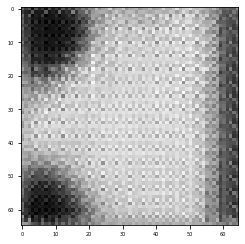

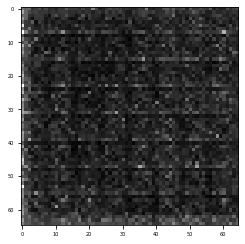

[Epoch 28/20000] [G_A loss: 4.276470] [D_B loss: 0.240745]

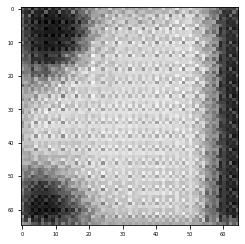

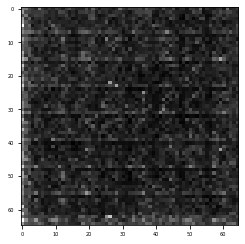

[Epoch 29/20000] [G_A loss: 4.284506] [D_B loss: 0.242774]

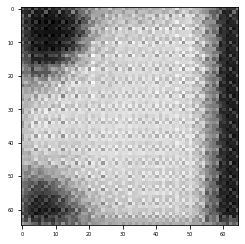

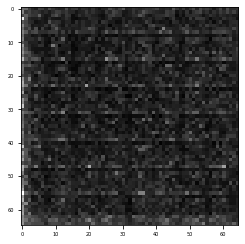

[Epoch 30/20000] [G_A loss: 4.278738] [D_B loss: 0.245855]

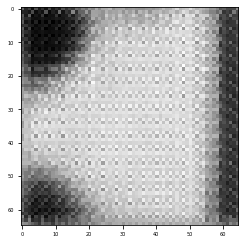

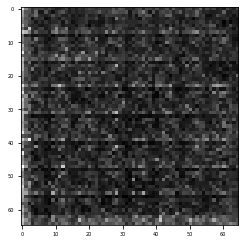

[Epoch 31/20000] [G_A loss: 4.263984] [D_B loss: 0.252941]

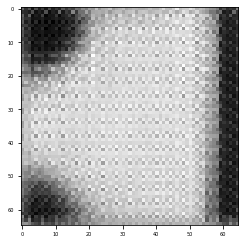

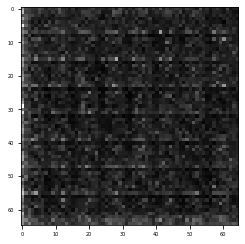

[Epoch 32/20000] [G_A loss: 4.251614] [D_B loss: 0.261661]

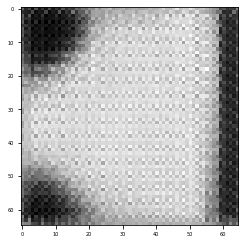

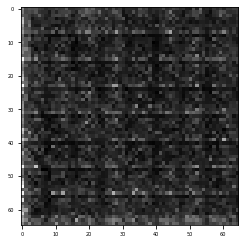

[Epoch 33/20000] [G_A loss: 4.278769] [D_B loss: 0.278650]

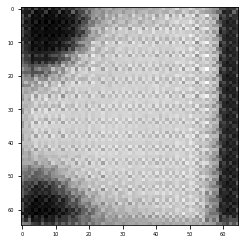

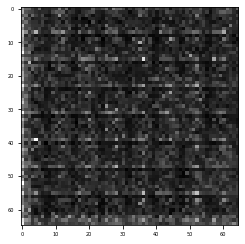

[Epoch 34/20000] [G_A loss: 4.259072] [D_B loss: 0.297777]

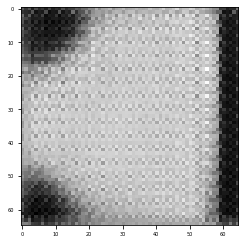

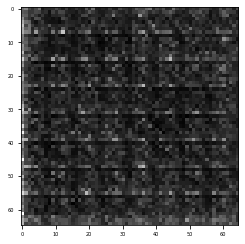

[Epoch 35/20000] [G_A loss: 4.317138] [D_B loss: 0.319384]

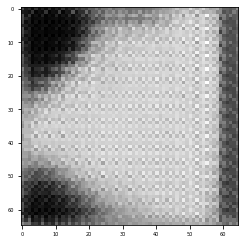

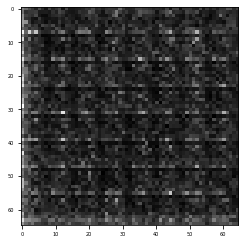

[Epoch 36/20000] [G_A loss: 4.331698] [D_B loss: 0.320082]

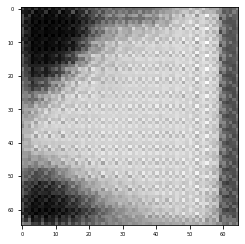

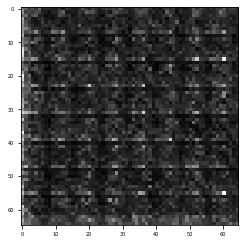

[Epoch 37/20000] [G_A loss: 4.343811] [D_B loss: 0.290438]

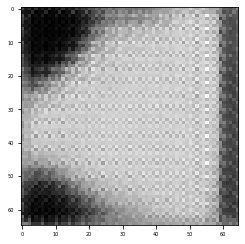

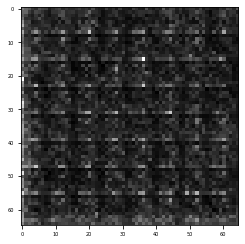

[Epoch 38/20000] [G_A loss: 4.314785] [D_B loss: 0.260112]

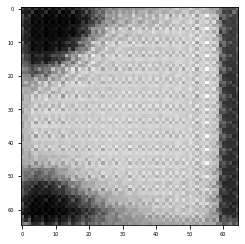

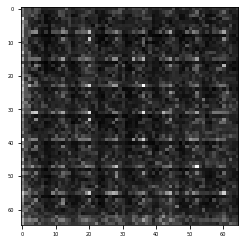

[Epoch 39/20000] [G_A loss: 4.251248] [D_B loss: 0.250516]

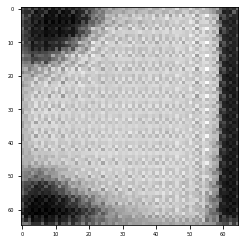

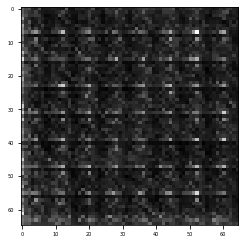

[Epoch 40/20000] [G_A loss: 4.277376] [D_B loss: 0.259072]

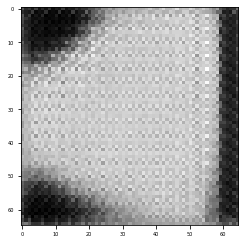

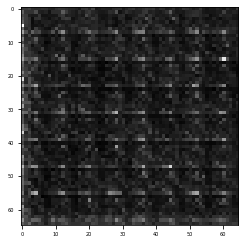

[Epoch 41/20000] [G_A loss: 4.230846] [D_B loss: 0.267946]

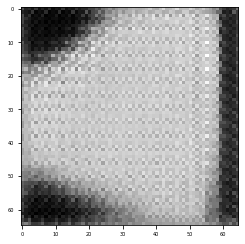

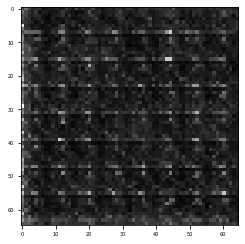

[Epoch 42/20000] [G_A loss: 4.228304] [D_B loss: 0.270294]

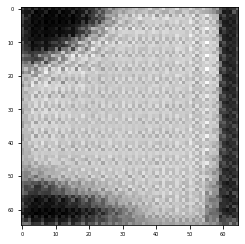

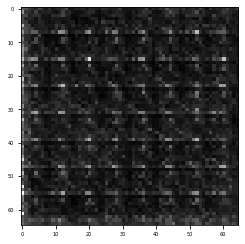

[Epoch 43/20000] [G_A loss: 4.289575] [D_B loss: 0.246980]

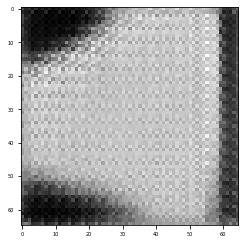

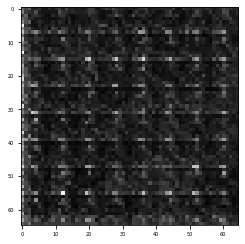

[Epoch 44/20000] [G_A loss: 4.147494] [D_B loss: 0.220235]

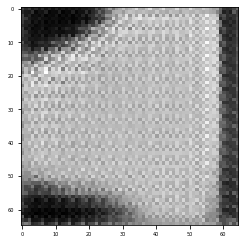

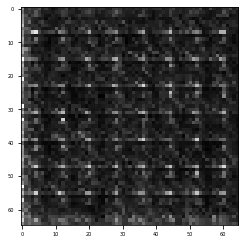

[Epoch 45/20000] [G_A loss: 4.377759] [D_B loss: 0.344823]

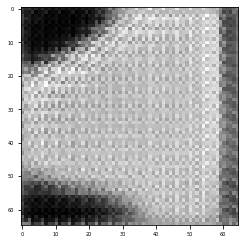

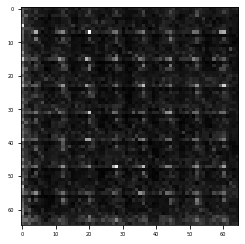

[Epoch 46/20000] [G_A loss: 4.186407] [D_B loss: 0.379304]

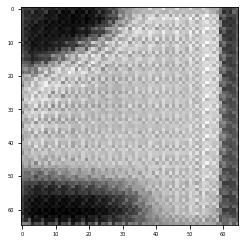

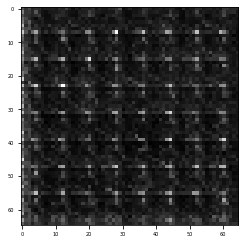

[Epoch 47/20000] [G_A loss: 4.250390] [D_B loss: 0.340729]

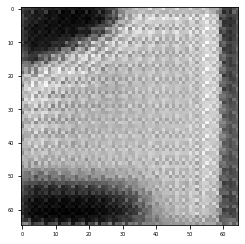

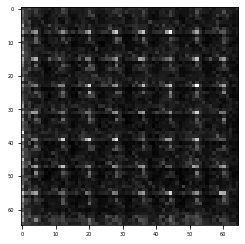

[Epoch 48/20000] [G_A loss: 4.258597] [D_B loss: 0.284633]

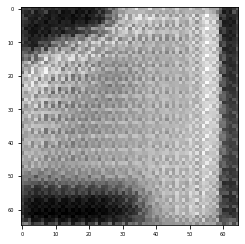

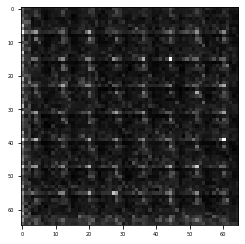

[Epoch 49/20000] [G_A loss: 4.168340] [D_B loss: 0.243112]

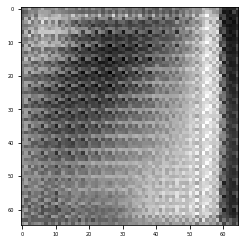

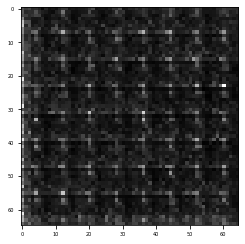

[Epoch 50/20000] [G_A loss: 4.235025] [D_B loss: 0.258848]

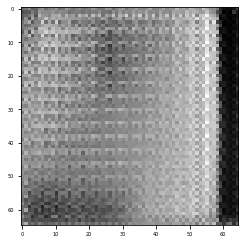

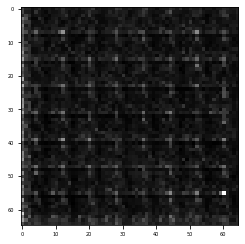

[Epoch 51/20000] [G_A loss: 4.224890] [D_B loss: 0.283691]

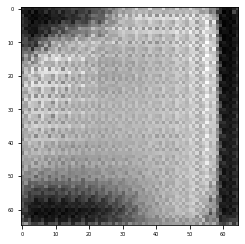

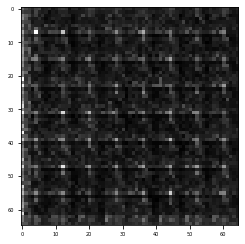

[Epoch 52/20000] [G_A loss: 4.248678] [D_B loss: 0.282850]

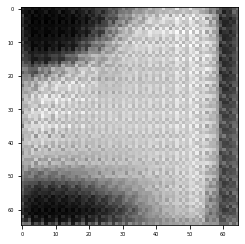

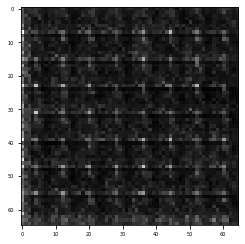

[Epoch 53/20000] [G_A loss: 4.181936] [D_B loss: 0.234286]

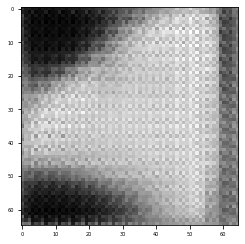

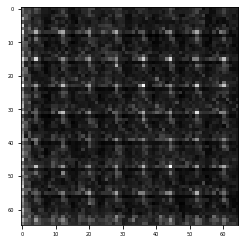

[Epoch 54/20000] [G_A loss: 4.188356] [D_B loss: 0.188390]

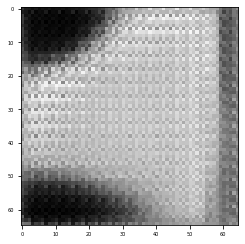

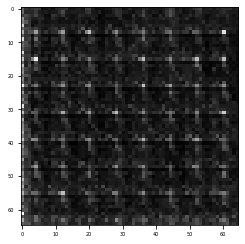

[Epoch 55/20000] [G_A loss: 4.232087] [D_B loss: 0.187124]

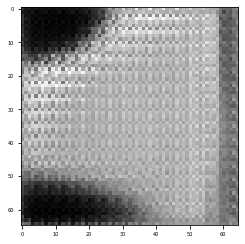

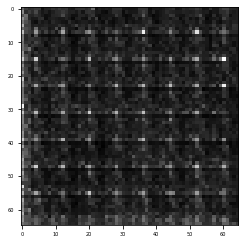

[Epoch 56/20000] [G_A loss: 4.179426] [D_B loss: 0.212260]

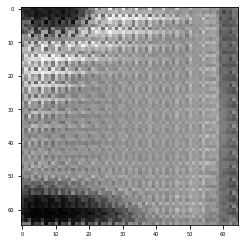

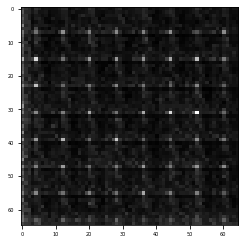

[Epoch 57/20000] [G_A loss: 4.208749] [D_B loss: 0.232963]

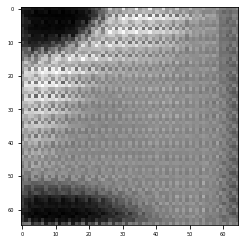

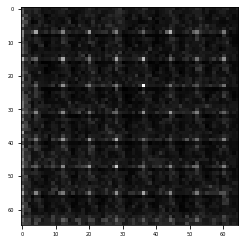

[Epoch 58/20000] [G_A loss: 4.165246] [D_B loss: 0.219164]

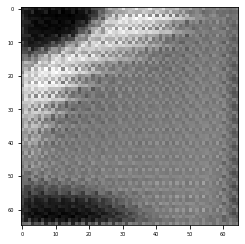

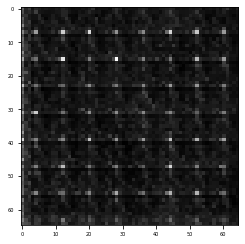

[Epoch 59/20000] [G_A loss: 4.175522] [D_B loss: 0.231852]

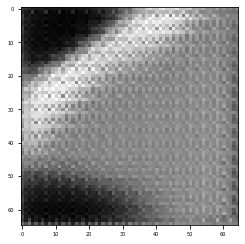

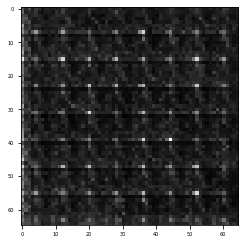

[Epoch 60/20000] [G_A loss: 4.138391] [D_B loss: 0.292031]

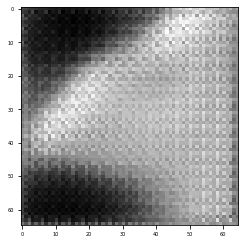

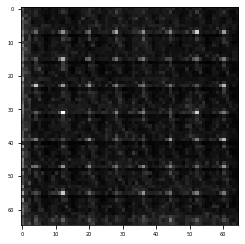

[Epoch 61/20000] [G_A loss: 4.195095] [D_B loss: 0.507733]

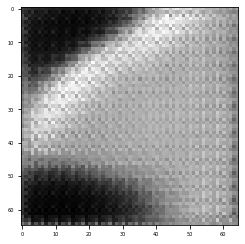

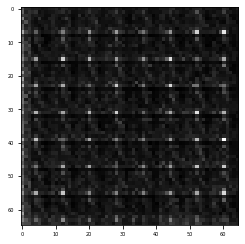

[Epoch 62/20000] [G_A loss: 4.162304] [D_B loss: 0.294764]

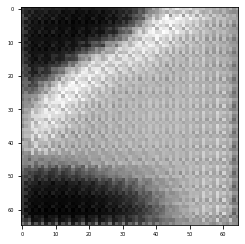

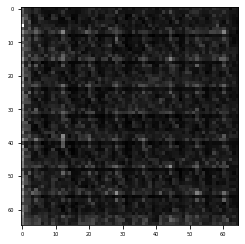

[Epoch 63/20000] [G_A loss: 4.171788] [D_B loss: 0.303249]

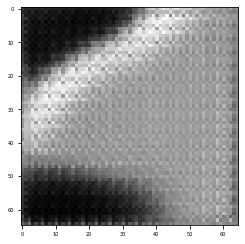

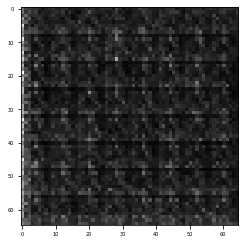

[Epoch 64/20000] [G_A loss: 4.177031] [D_B loss: 0.252412]

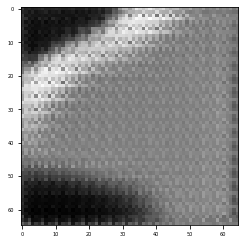

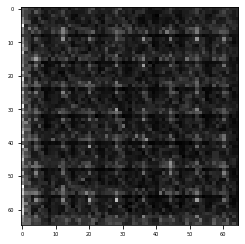

[Epoch 65/20000] [G_A loss: 4.211792] [D_B loss: 0.249288]

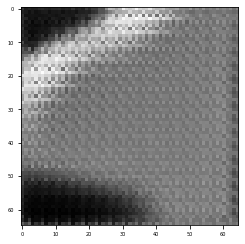

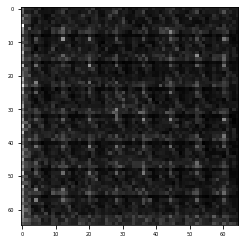

[Epoch 66/20000] [G_A loss: 4.183346] [D_B loss: 0.230774]

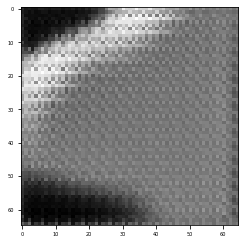

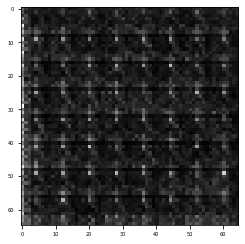

[Epoch 67/20000] [G_A loss: 4.238631] [D_B loss: 0.225313]

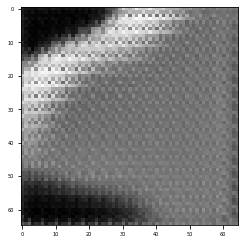

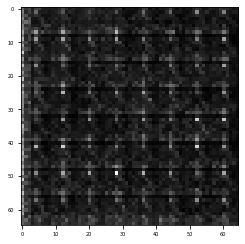

[Epoch 68/20000] [G_A loss: 4.152213] [D_B loss: 0.219498]

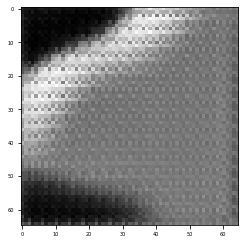

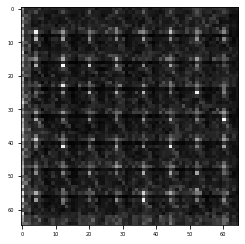

[Epoch 69/20000] [G_A loss: 4.160401] [D_B loss: 0.218119]

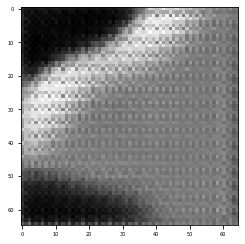

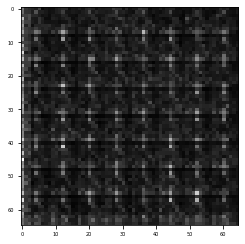

[Epoch 70/20000] [G_A loss: 4.236359] [D_B loss: 0.210802]

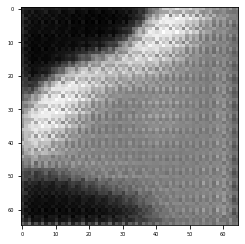

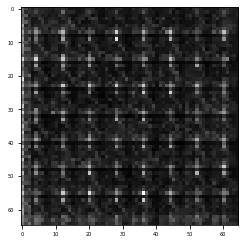

[Epoch 71/20000] [G_A loss: 4.279922] [D_B loss: 0.212679]

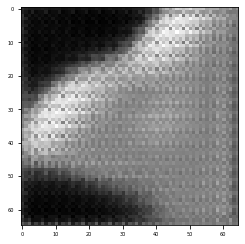

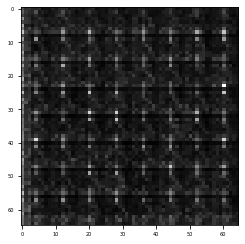

[Epoch 72/20000] [G_A loss: 4.175889] [D_B loss: 0.197906]

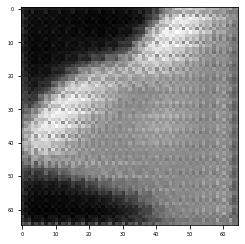

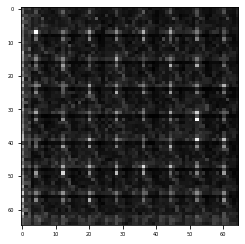

[Epoch 73/20000] [G_A loss: 4.113126] [D_B loss: 0.194940]

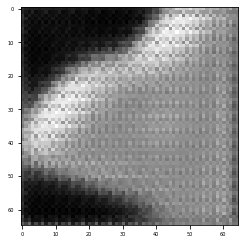

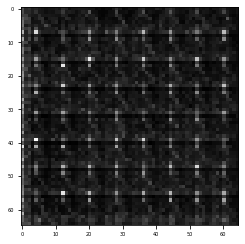

[Epoch 74/20000] [G_A loss: 4.112875] [D_B loss: 0.200360]

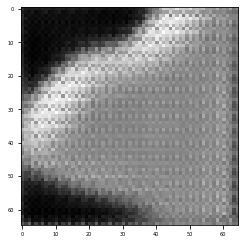

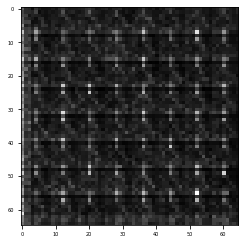

[Epoch 75/20000] [G_A loss: 4.115237] [D_B loss: 0.216943]

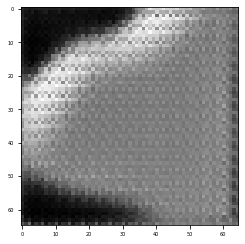

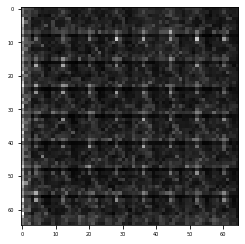

[Epoch 76/20000] [G_A loss: 4.198976] [D_B loss: 0.248202]

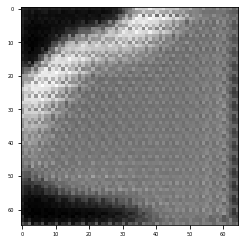

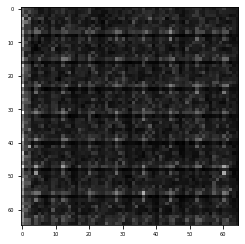

[Epoch 77/20000] [G_A loss: 4.160418] [D_B loss: 0.302563]

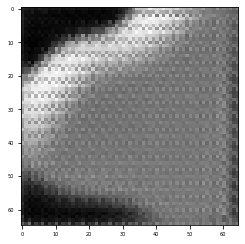

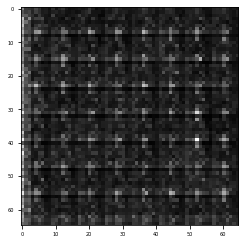

[Epoch 78/20000] [G_A loss: 4.286760] [D_B loss: 0.367687]

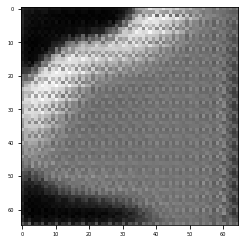

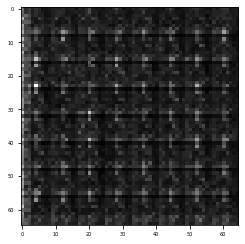

[Epoch 79/20000] [G_A loss: 4.152740] [D_B loss: 0.345752]

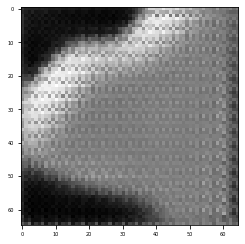

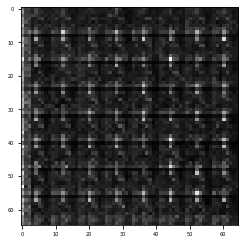

[Epoch 80/20000] [G_A loss: 4.246245] [D_B loss: 0.330095]

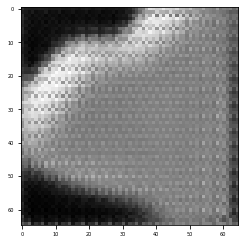

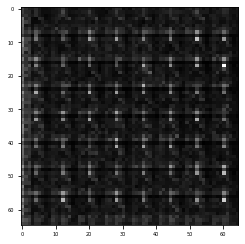

[Epoch 81/20000] [G_A loss: 4.101762] [D_B loss: 0.337655]

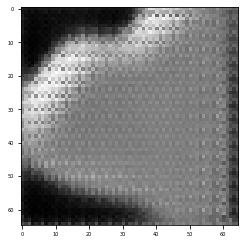

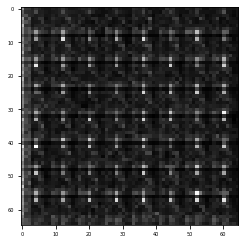

[Epoch 82/20000] [G_A loss: 4.371966] [D_B loss: 0.306992]

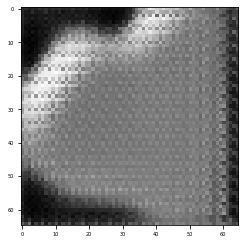

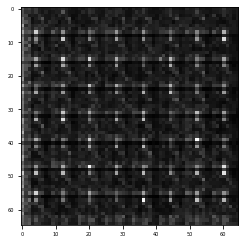

[Epoch 83/20000] [G_A loss: 4.063791] [D_B loss: 0.232562]

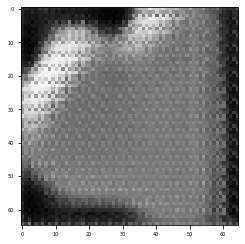

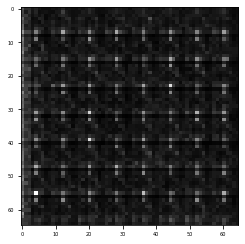

[Epoch 84/20000] [G_A loss: 4.200377] [D_B loss: 0.204936]

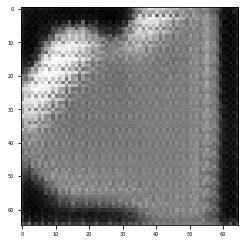

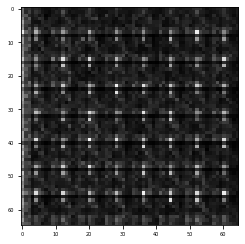

[Epoch 85/20000] [G_A loss: 4.192149] [D_B loss: 0.199531]

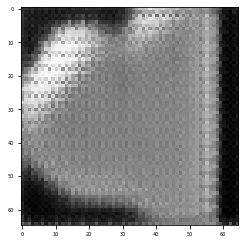

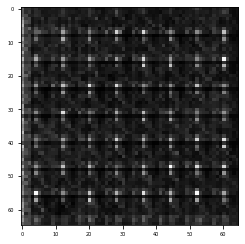

[Epoch 86/20000] [G_A loss: 4.174205] [D_B loss: 0.192667]

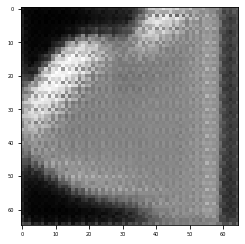

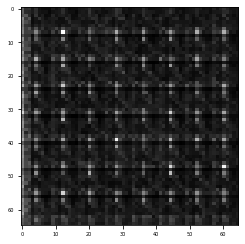

[Epoch 87/20000] [G_A loss: 4.165705] [D_B loss: 0.178203]

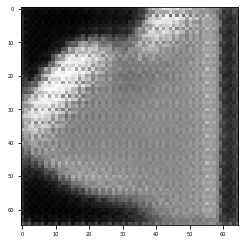

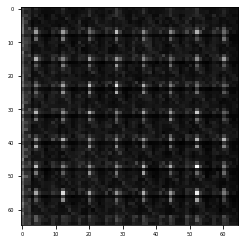

[Epoch 88/20000] [G_A loss: 4.192088] [D_B loss: 0.189678]

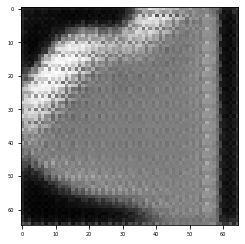

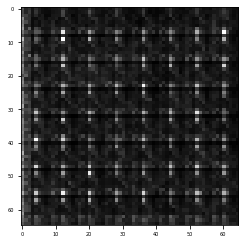

[Epoch 89/20000] [G_A loss: 4.133835] [D_B loss: 0.185332]

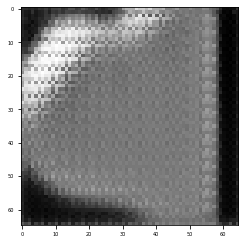

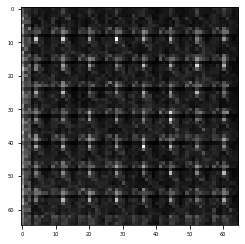

[Epoch 90/20000] [G_A loss: 4.227559] [D_B loss: 0.176080]

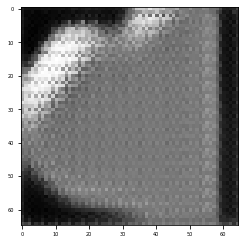

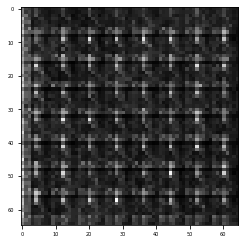

[Epoch 91/20000] [G_A loss: 4.197435] [D_B loss: 0.195689]

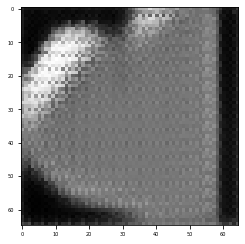

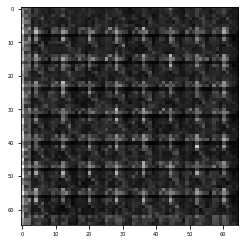

[Epoch 92/20000] [G_A loss: 4.341747] [D_B loss: 0.222569]

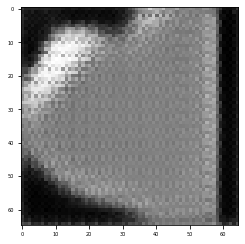

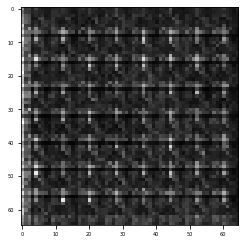

[Epoch 93/20000] [G_A loss: 4.002063] [D_B loss: 0.347668]

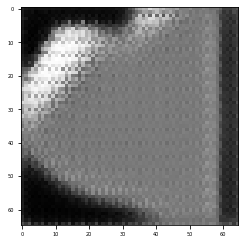

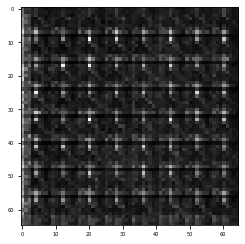

[Epoch 94/20000] [G_A loss: 4.495757] [D_B loss: 0.327854]

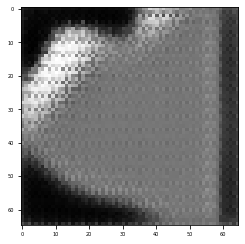

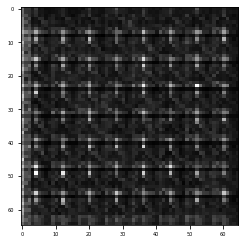

[Epoch 95/20000] [G_A loss: 4.085504] [D_B loss: 0.220592]

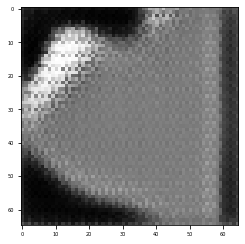

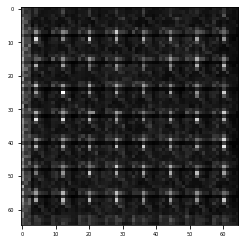

[Epoch 96/20000] [G_A loss: 4.269090] [D_B loss: 0.214646]

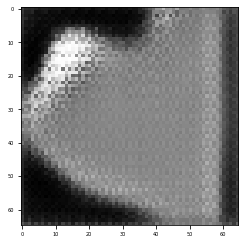

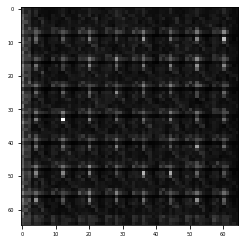

[Epoch 97/20000] [G_A loss: 4.502394] [D_B loss: 0.219880]

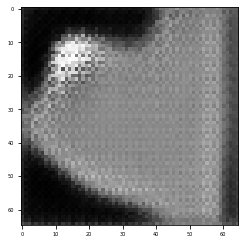

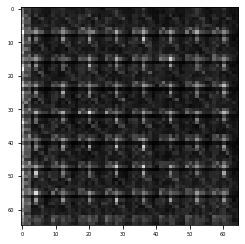

[Epoch 98/20000] [G_A loss: 4.048770] [D_B loss: 0.198485]

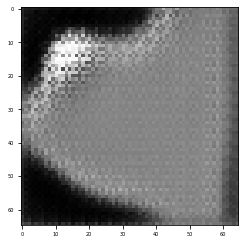

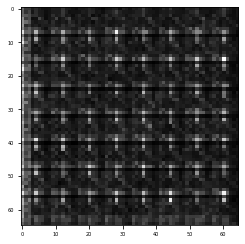

[Epoch 99/20000] [G_A loss: 4.470506] [D_B loss: 0.200091]

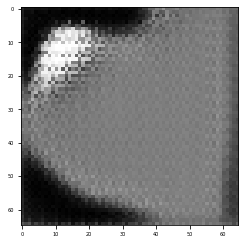

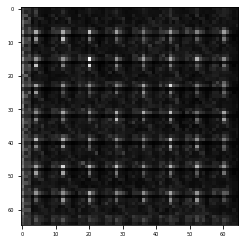

[Epoch 100/20000] [G_A loss: 4.592875] [D_B loss: 0.222952]

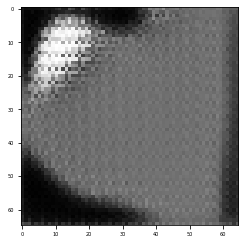

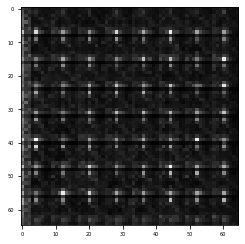

[Epoch 101/20000] [G_A loss: 3.961888] [D_B loss: 0.245449]

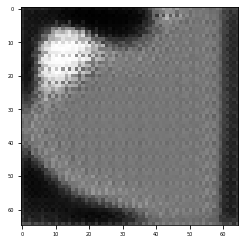

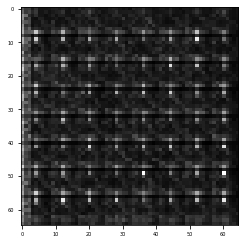

[Epoch 102/20000] [G_A loss: 4.908413] [D_B loss: 0.281590]

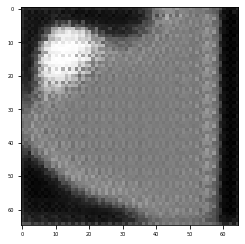

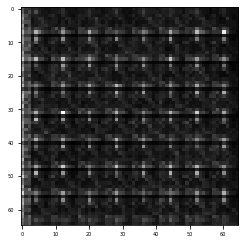

[Epoch 103/20000] [G_A loss: 4.127774] [D_B loss: 0.361013]

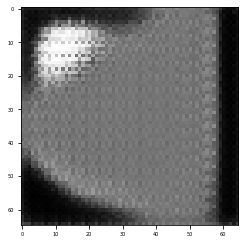

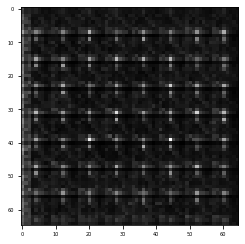

[Epoch 104/20000] [G_A loss: 4.332968] [D_B loss: 0.349984]

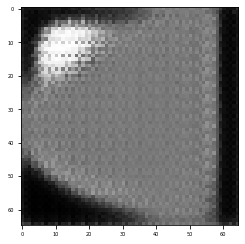

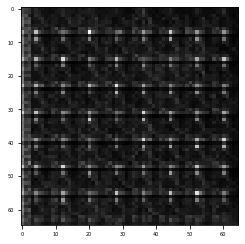

[Epoch 105/20000] [G_A loss: 4.219327] [D_B loss: 0.276562]

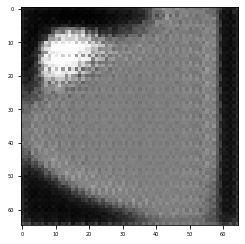

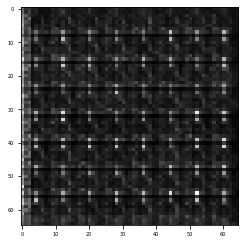

[Epoch 106/20000] [G_A loss: 4.315361] [D_B loss: 0.258102]

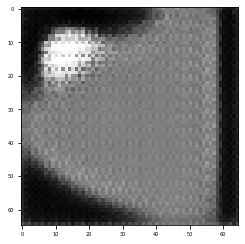

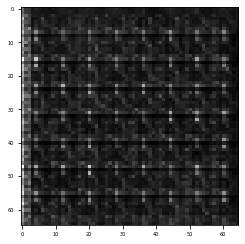

[Epoch 107/20000] [G_A loss: 4.346253] [D_B loss: 0.270128]

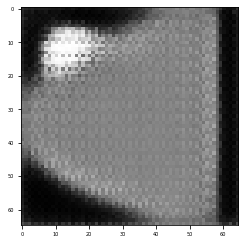

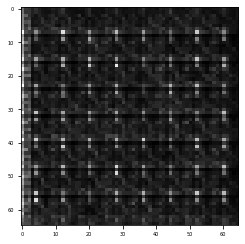

[Epoch 108/20000] [G_A loss: 4.303248] [D_B loss: 0.262855]

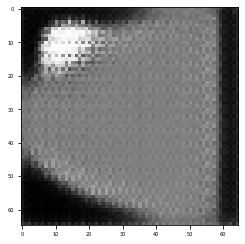

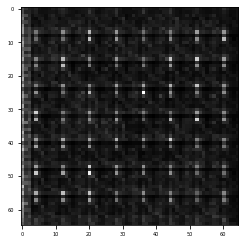

[Epoch 109/20000] [G_A loss: 4.489846] [D_B loss: 0.234188]

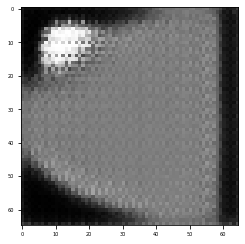

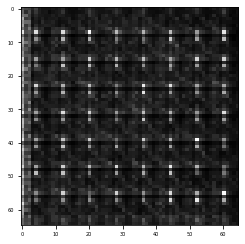

[Epoch 110/20000] [G_A loss: 4.425145] [D_B loss: 0.207561]

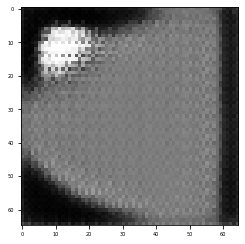

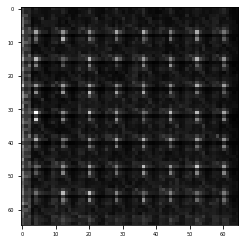

[Epoch 111/20000] [G_A loss: 4.646214] [D_B loss: 0.200781]

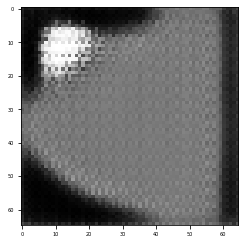

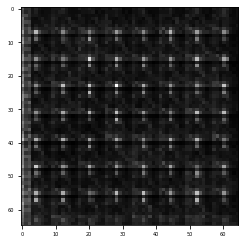

[Epoch 112/20000] [G_A loss: 4.528047] [D_B loss: 0.199845]

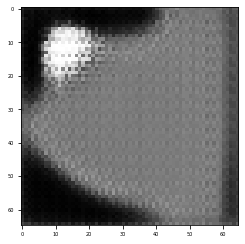

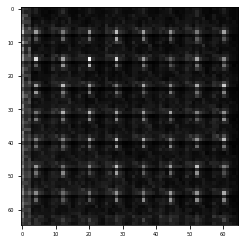

[Epoch 113/20000] [G_A loss: 4.698195] [D_B loss: 0.201257]

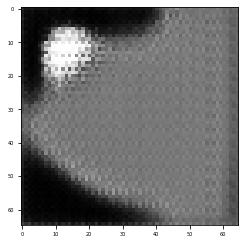

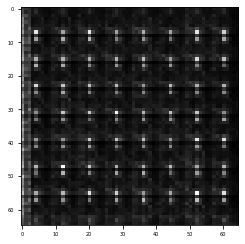

[Epoch 114/20000] [G_A loss: 4.668046] [D_B loss: 0.195780]

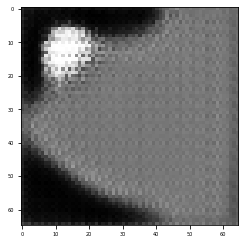

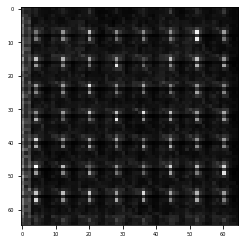

[Epoch 115/20000] [G_A loss: 4.389826] [D_B loss: 0.202597]

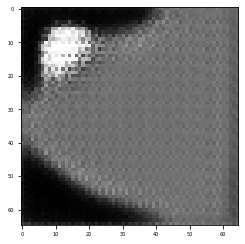

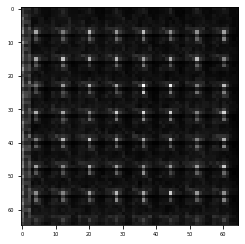

[Epoch 116/20000] [G_A loss: 5.651634] [D_B loss: 0.210442]

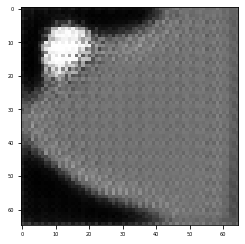

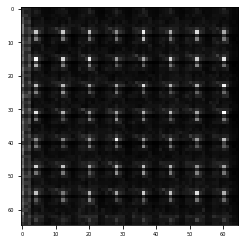

[Epoch 117/20000] [G_A loss: 3.786182] [D_B loss: 0.223598]

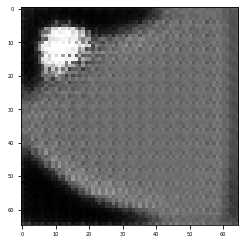

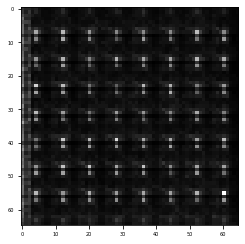

[Epoch 118/20000] [G_A loss: 5.737190] [D_B loss: 0.229810]

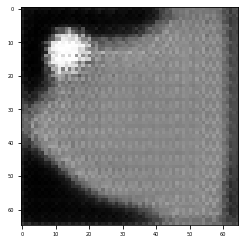

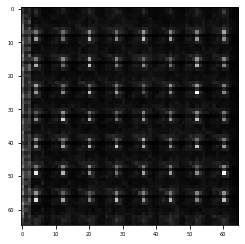

[Epoch 119/20000] [G_A loss: 3.883077] [D_B loss: 0.276336]

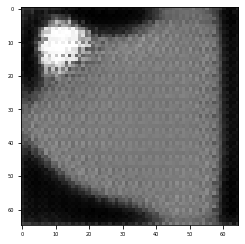

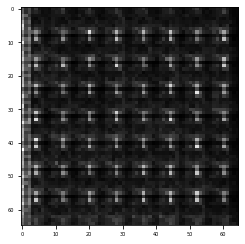

[Epoch 120/20000] [G_A loss: 3.917443] [D_B loss: 0.283468]

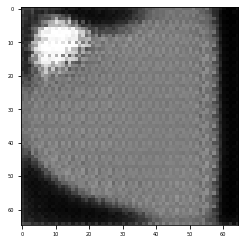

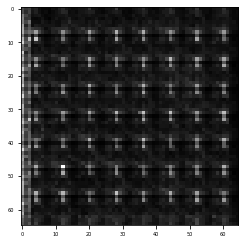

[Epoch 121/20000] [G_A loss: 4.300803] [D_B loss: 0.255572]

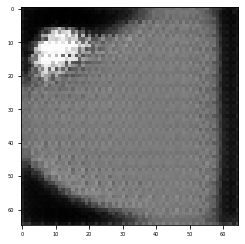

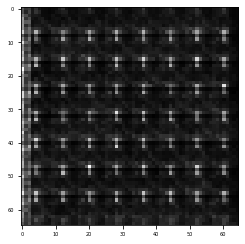

[Epoch 122/20000] [G_A loss: 4.292733] [D_B loss: 0.237149]

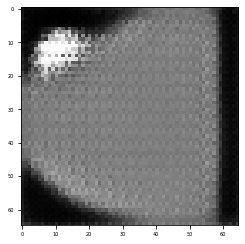

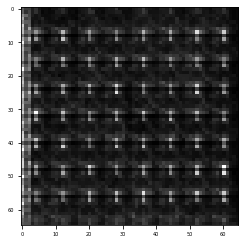

[Epoch 123/20000] [G_A loss: 4.188935] [D_B loss: 0.259361]

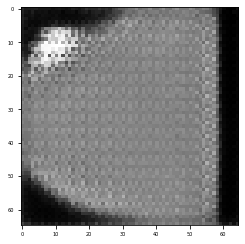

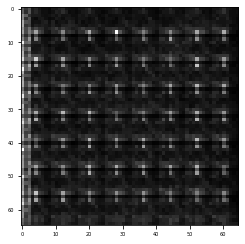

[Epoch 124/20000] [G_A loss: 4.224235] [D_B loss: 0.280079]

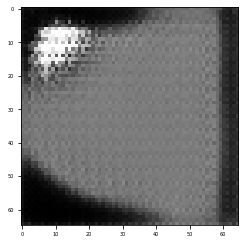

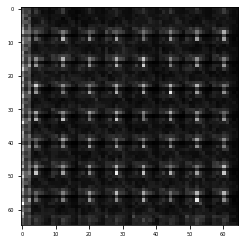

[Epoch 125/20000] [G_A loss: 4.447151] [D_B loss: 0.284231]

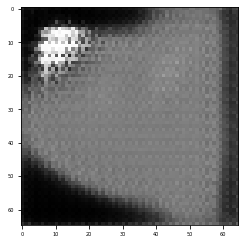

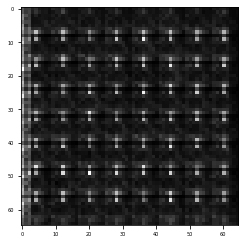

[Epoch 126/20000] [G_A loss: 4.456908] [D_B loss: 0.255223]

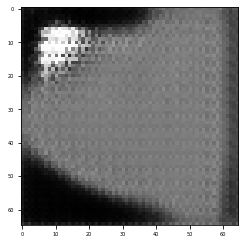

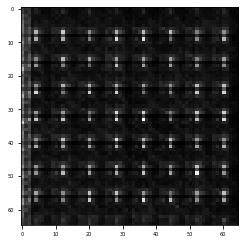

[Epoch 127/20000] [G_A loss: 4.459922] [D_B loss: 0.218904]

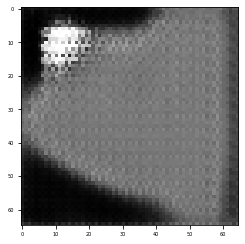

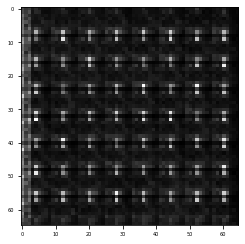

[Epoch 128/20000] [G_A loss: 4.582041] [D_B loss: 0.200619]

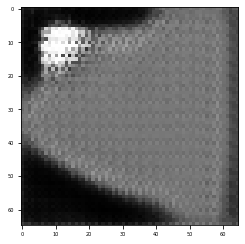

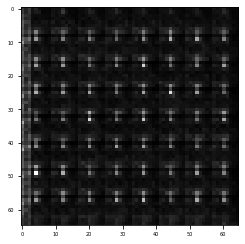

[Epoch 129/20000] [G_A loss: 4.633114] [D_B loss: 0.209763]

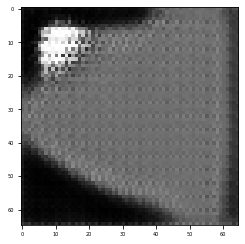

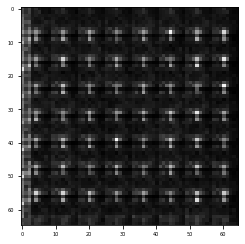

[Epoch 130/20000] [G_A loss: 4.579057] [D_B loss: 0.213308]

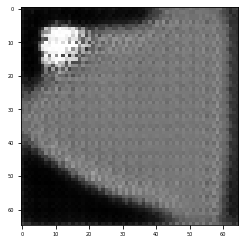

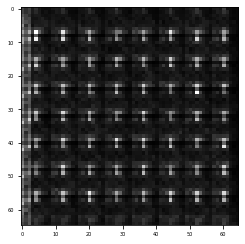

[Epoch 131/20000] [G_A loss: 4.598567] [D_B loss: 0.254833]

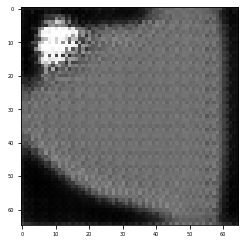

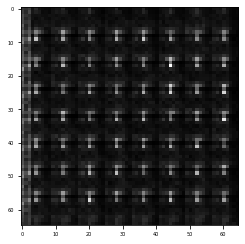

[Epoch 132/20000] [G_A loss: 4.487831] [D_B loss: 0.287513]

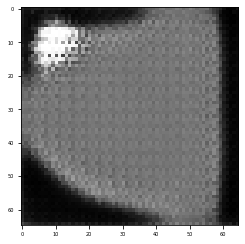

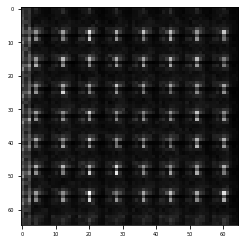

[Epoch 133/20000] [G_A loss: 4.423126] [D_B loss: 0.275159]

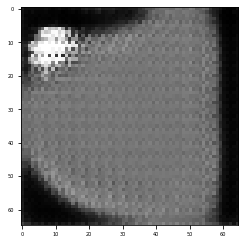

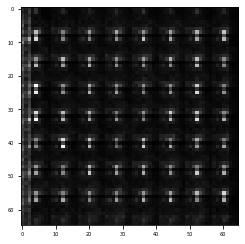

[Epoch 134/20000] [G_A loss: 4.524571] [D_B loss: 0.232253]

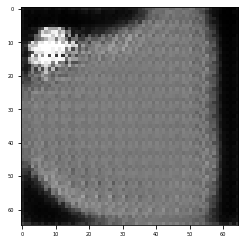

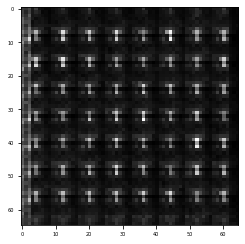

[Epoch 135/20000] [G_A loss: 4.547779] [D_B loss: 0.218222]

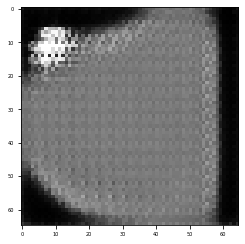

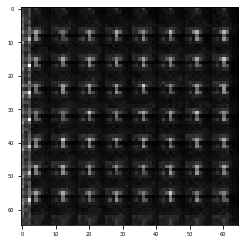

[Epoch 136/20000] [G_A loss: 4.467944] [D_B loss: 0.216777]

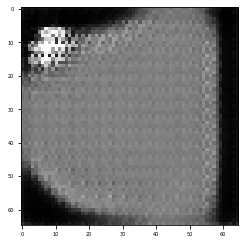

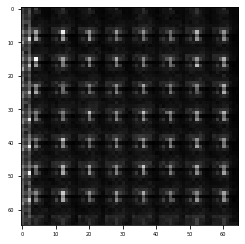

[Epoch 137/20000] [G_A loss: 4.990272] [D_B loss: 0.218223]

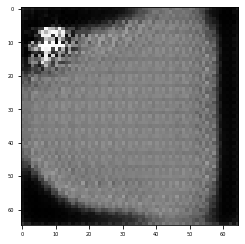

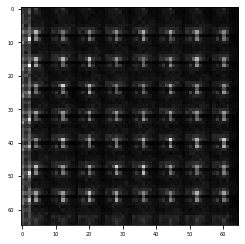

[Epoch 138/20000] [G_A loss: 4.164489] [D_B loss: 0.208898]

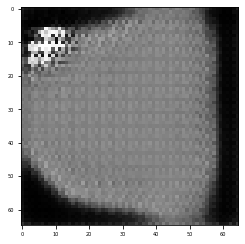

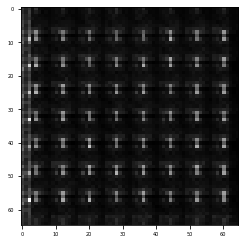

[Epoch 139/20000] [G_A loss: 4.680946] [D_B loss: 0.213804]

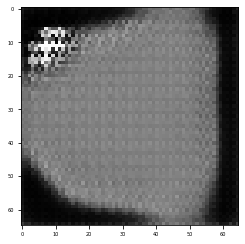

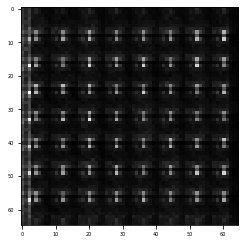

[Epoch 140/20000] [G_A loss: 4.541228] [D_B loss: 0.224098]

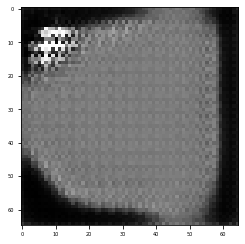

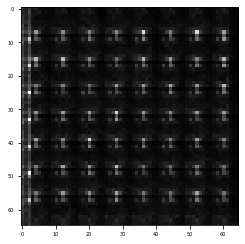

[Epoch 141/20000] [G_A loss: 4.424355] [D_B loss: 0.240880]

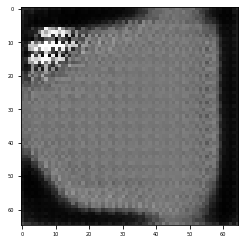

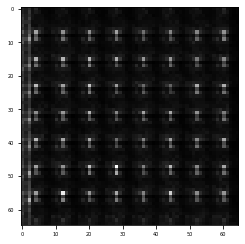

[Epoch 142/20000] [G_A loss: 4.587623] [D_B loss: 0.260626]

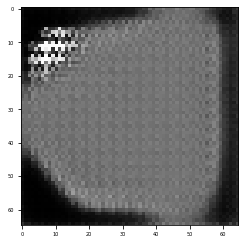

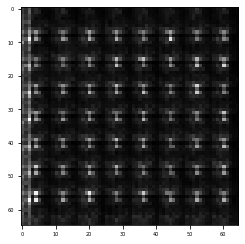

[Epoch 143/20000] [G_A loss: 4.572605] [D_B loss: 0.268014]

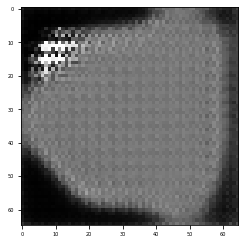

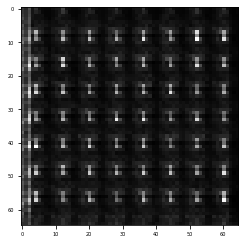

[Epoch 144/20000] [G_A loss: 4.529601] [D_B loss: 0.273733]

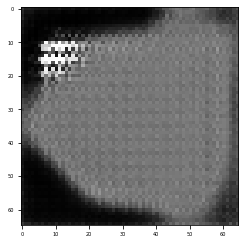

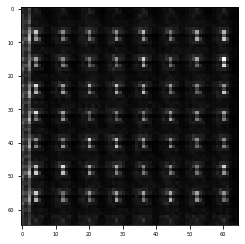

[Epoch 145/20000] [G_A loss: 4.539106] [D_B loss: 0.273100]

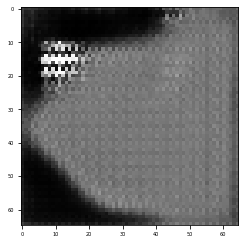

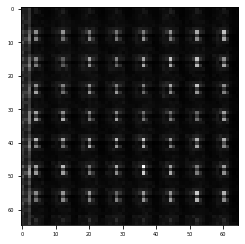

[Epoch 146/20000] [G_A loss: 4.578985] [D_B loss: 0.294831]

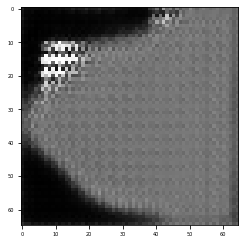

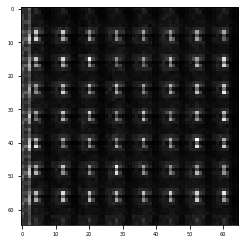

[Epoch 147/20000] [G_A loss: 4.582747] [D_B loss: 0.281793]

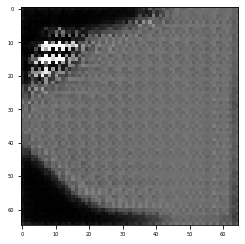

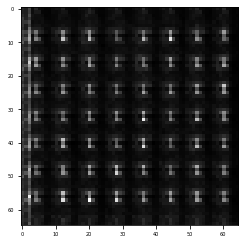

[Epoch 148/20000] [G_A loss: 4.453622] [D_B loss: 0.236365]

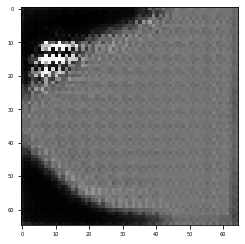

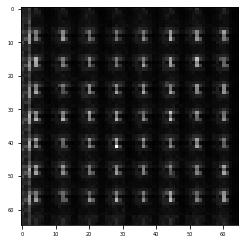

[Epoch 149/20000] [G_A loss: 4.743079] [D_B loss: 0.214477]

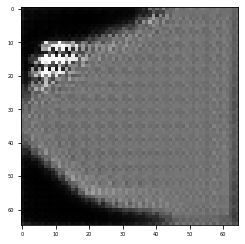

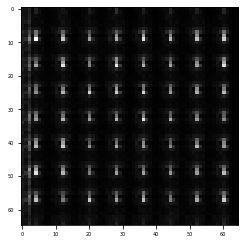

[Epoch 150/20000] [G_A loss: 4.517920] [D_B loss: 0.209365]

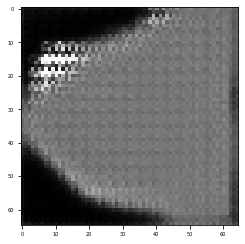

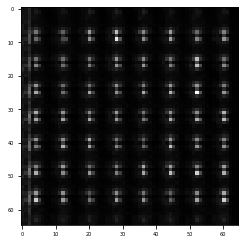

[Epoch 151/20000] [G_A loss: 4.790853] [D_B loss: 0.202231]

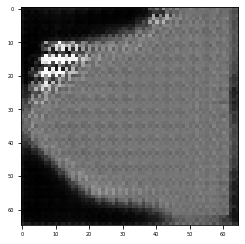

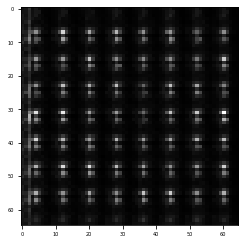

[Epoch 152/20000] [G_A loss: 4.435259] [D_B loss: 0.198944]

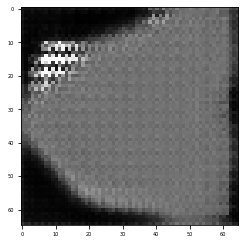

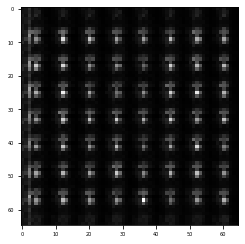

[Epoch 153/20000] [G_A loss: 4.834156] [D_B loss: 0.191912]

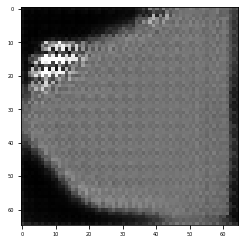

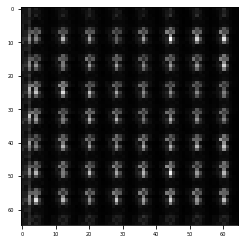

[Epoch 154/20000] [G_A loss: 4.541821] [D_B loss: 0.192809]

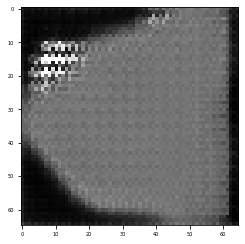

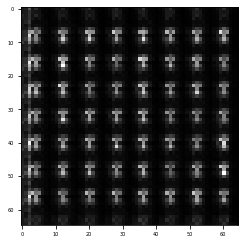

[Epoch 155/20000] [G_A loss: 4.565220] [D_B loss: 0.184170]

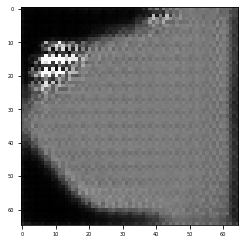

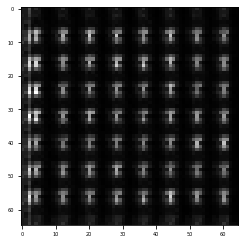

[Epoch 156/20000] [G_A loss: 4.671261] [D_B loss: 0.200782]

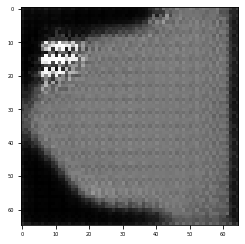

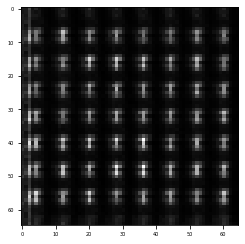

[Epoch 157/20000] [G_A loss: 4.585536] [D_B loss: 0.217775]

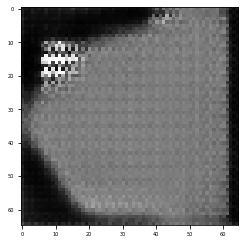

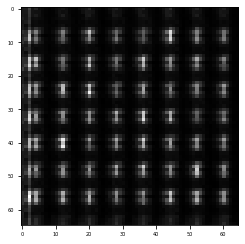

[Epoch 158/20000] [G_A loss: 4.591488] [D_B loss: 0.305117]

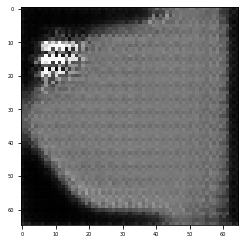

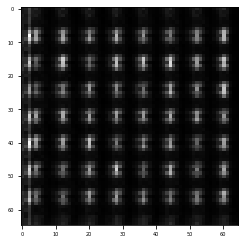

[Epoch 159/20000] [G_A loss: 4.587210] [D_B loss: 0.486160]

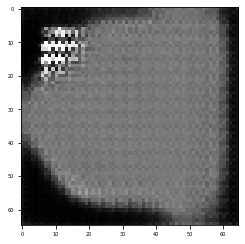

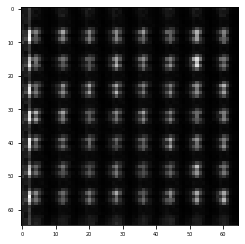

[Epoch 160/20000] [G_A loss: 4.513459] [D_B loss: 0.481343]

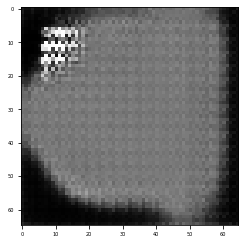

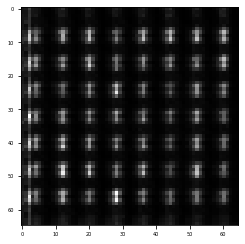

[Epoch 161/20000] [G_A loss: 4.848968] [D_B loss: 0.344961]

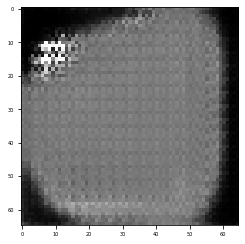

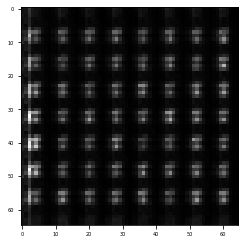

[Epoch 162/20000] [G_A loss: 4.468418] [D_B loss: 0.315439]

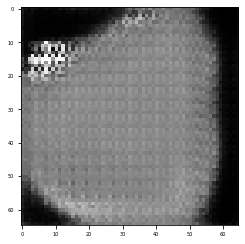

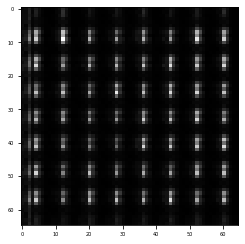

[Epoch 163/20000] [G_A loss: 5.259116] [D_B loss: 0.285602]

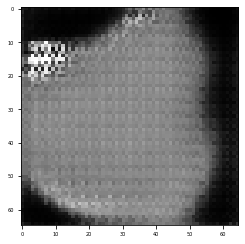

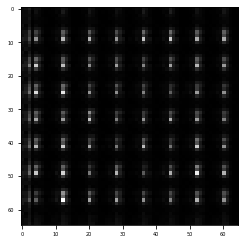

[Epoch 164/20000] [G_A loss: 3.857335] [D_B loss: 0.281502]

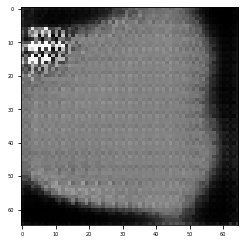

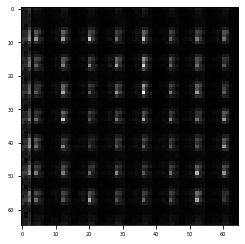

[Epoch 165/20000] [G_A loss: 4.600998] [D_B loss: 0.246168]

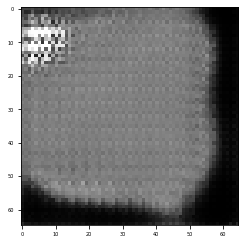

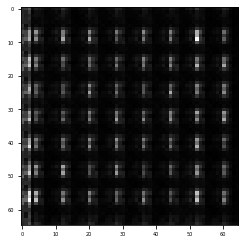

[Epoch 166/20000] [G_A loss: 4.542382] [D_B loss: 0.222040]

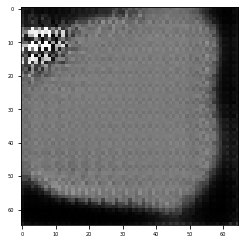

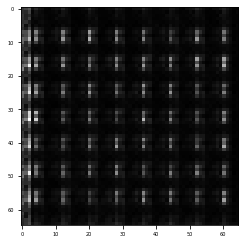

[Epoch 167/20000] [G_A loss: 4.290100] [D_B loss: 0.222270]

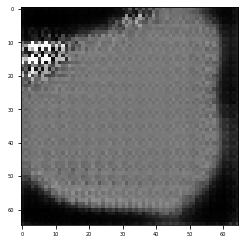

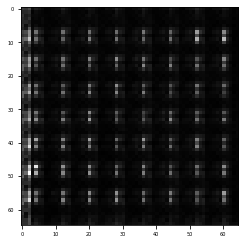

[Epoch 168/20000] [G_A loss: 4.468836] [D_B loss: 0.228614]

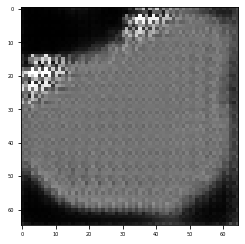

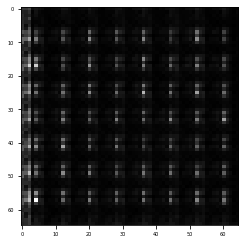

[Epoch 169/20000] [G_A loss: 4.547224] [D_B loss: 0.223891]

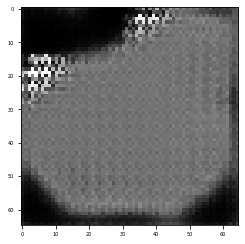

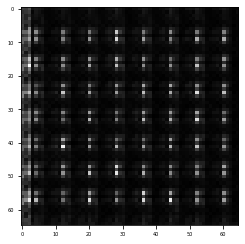

[Epoch 170/20000] [G_A loss: 4.449094] [D_B loss: 0.221521]

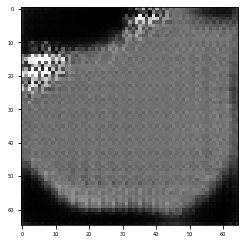

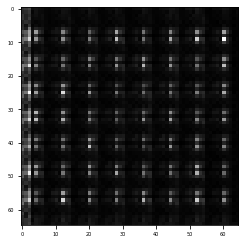

[Epoch 171/20000] [G_A loss: 4.434208] [D_B loss: 0.221727]

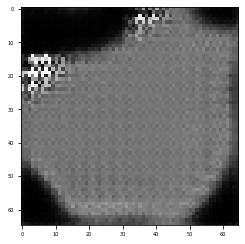

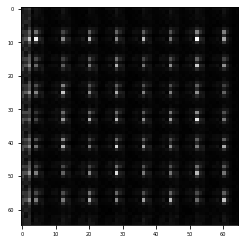

[Epoch 172/20000] [G_A loss: 4.527170] [D_B loss: 0.221486]

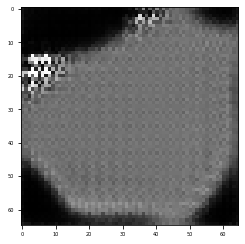

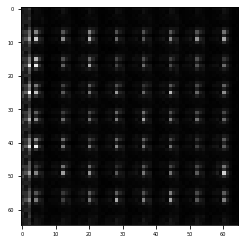

[Epoch 173/20000] [G_A loss: 4.467608] [D_B loss: 0.217437]

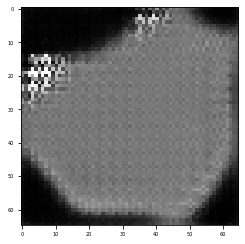

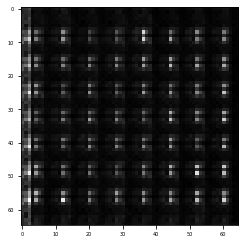

[Epoch 174/20000] [G_A loss: 4.479887] [D_B loss: 0.219387]

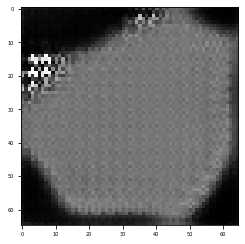

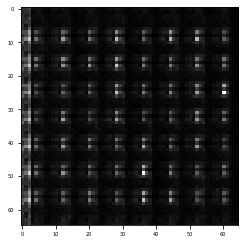

[Epoch 175/20000] [G_A loss: 4.448212] [D_B loss: 0.210137]

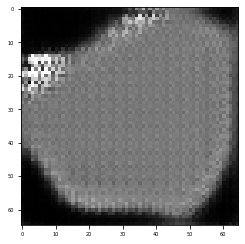

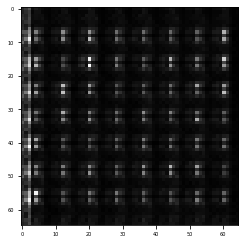

[Epoch 176/20000] [G_A loss: 4.454004] [D_B loss: 0.231213]

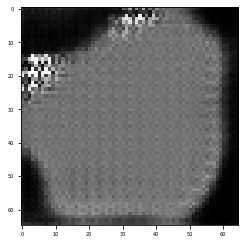

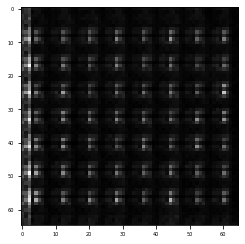

[Epoch 177/20000] [G_A loss: 4.432145] [D_B loss: 0.252930]

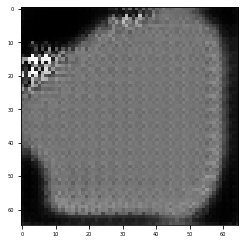

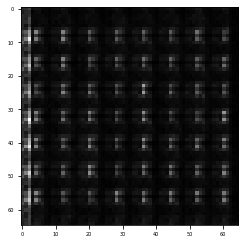

[Epoch 178/20000] [G_A loss: 4.457255] [D_B loss: 0.301711]

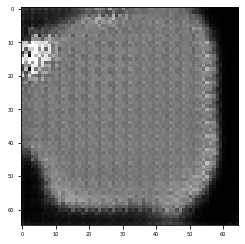

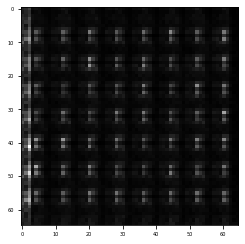

[Epoch 179/20000] [G_A loss: 4.443205] [D_B loss: 0.300611]

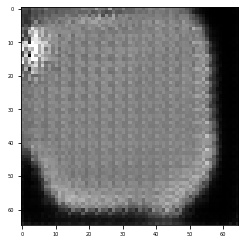

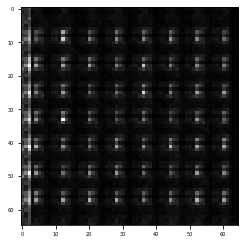

[Epoch 180/20000] [G_A loss: 4.448290] [D_B loss: 0.254618]

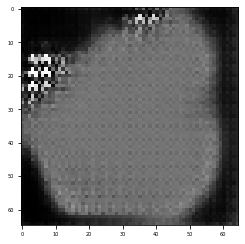

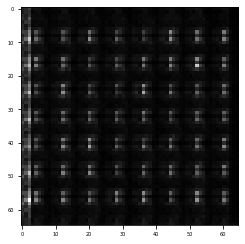

[Epoch 181/20000] [G_A loss: 4.417122] [D_B loss: 0.214269]

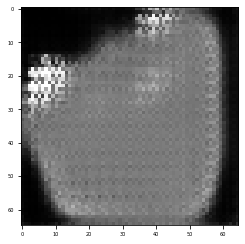

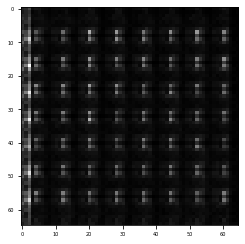

[Epoch 182/20000] [G_A loss: 4.430147] [D_B loss: 0.220415]

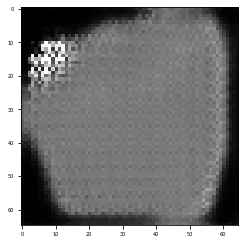

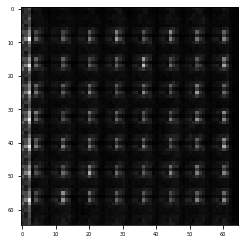

[Epoch 183/20000] [G_A loss: 4.392234] [D_B loss: 0.223735]

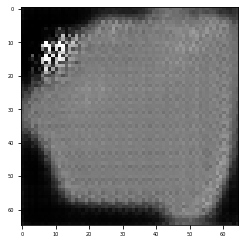

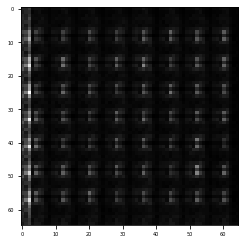

[Epoch 184/20000] [G_A loss: 4.474014] [D_B loss: 0.220208]

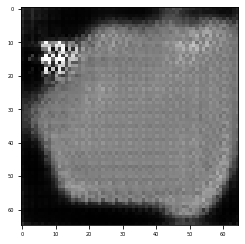

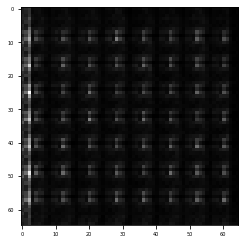

[Epoch 185/20000] [G_A loss: 4.422588] [D_B loss: 0.214788]

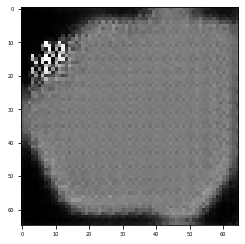

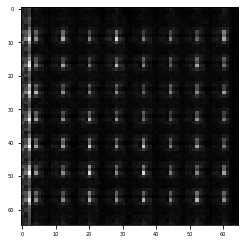

[Epoch 186/20000] [G_A loss: 4.489859] [D_B loss: 0.231670]

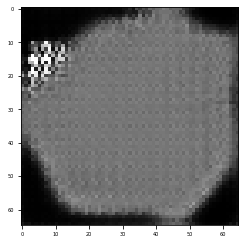

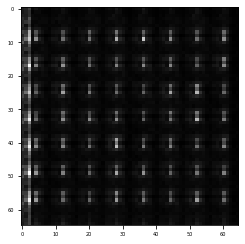

[Epoch 187/20000] [G_A loss: 4.422064] [D_B loss: 0.274291]

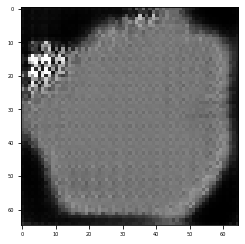

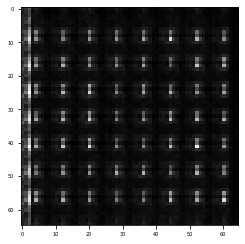

[Epoch 188/20000] [G_A loss: 4.412190] [D_B loss: 0.372457]

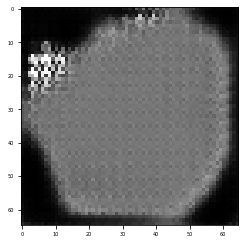

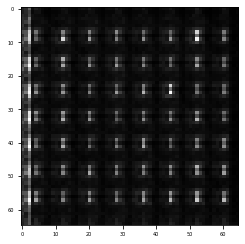

[Epoch 189/20000] [G_A loss: 4.394026] [D_B loss: 0.372535]

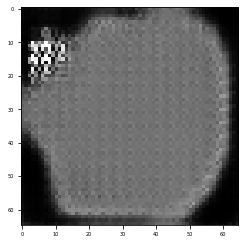

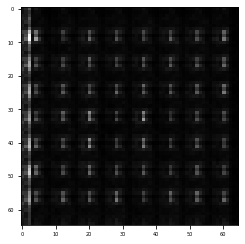

[Epoch 190/20000] [G_A loss: 4.411131] [D_B loss: 0.265218]

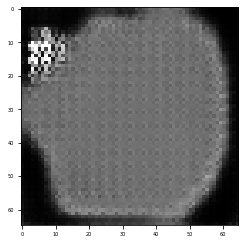

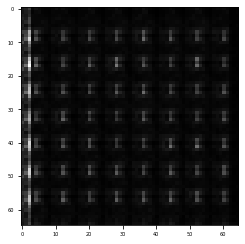

[Epoch 191/20000] [G_A loss: 4.398465] [D_B loss: 0.230679]

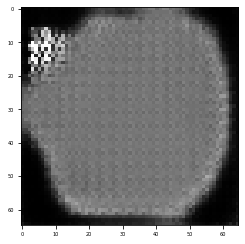

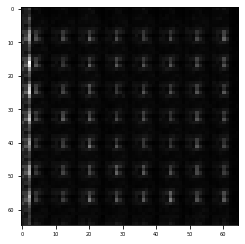

[Epoch 192/20000] [G_A loss: 4.403869] [D_B loss: 0.241973]

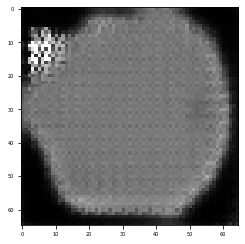

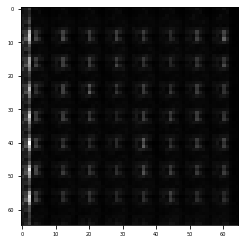

[Epoch 193/20000] [G_A loss: 4.410368] [D_B loss: 0.229529]

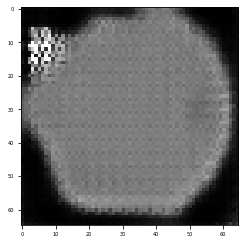

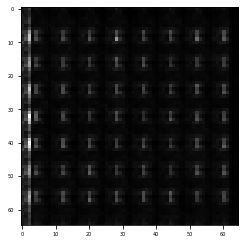

[Epoch 194/20000] [G_A loss: 4.445908] [D_B loss: 0.229388]

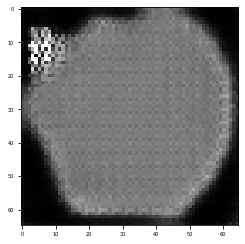

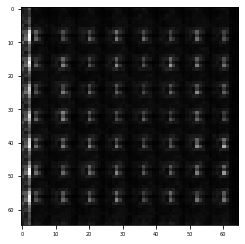

[Epoch 195/20000] [G_A loss: 4.358687] [D_B loss: 0.232253]

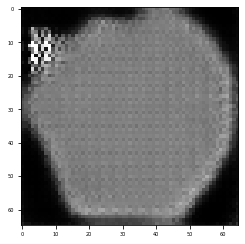

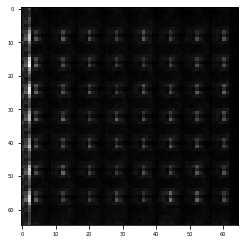

[Epoch 196/20000] [G_A loss: 4.413894] [D_B loss: 0.228459]

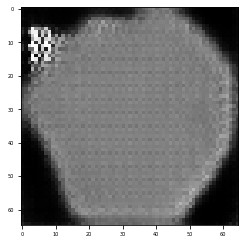

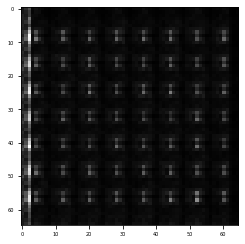

[Epoch 197/20000] [G_A loss: 4.376616] [D_B loss: 0.226583]

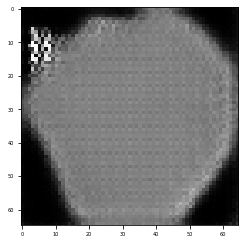

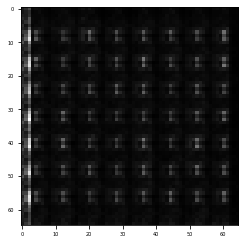

[Epoch 198/20000] [G_A loss: 4.373276] [D_B loss: 0.228078]

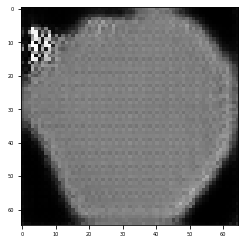

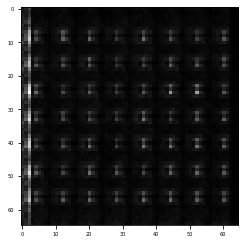

[Epoch 199/20000] [G_A loss: 4.376683] [D_B loss: 0.232333]

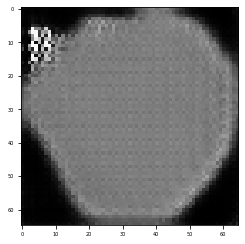

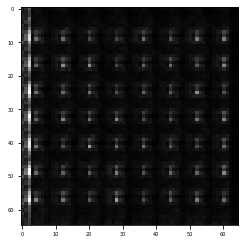

[Epoch 200/20000] [G_A loss: 4.361434] [D_B loss: 0.246212]

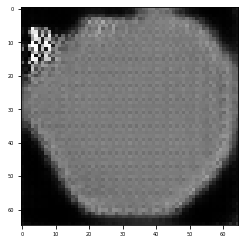

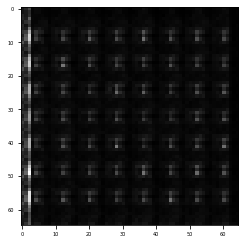

[Epoch 201/20000] [G_A loss: 4.363244] [D_B loss: 0.260918]

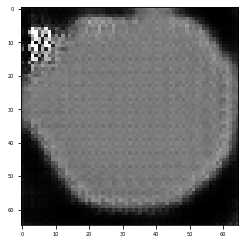

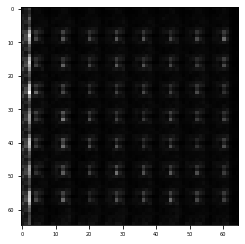

[Epoch 202/20000] [G_A loss: 4.430079] [D_B loss: 0.274941]

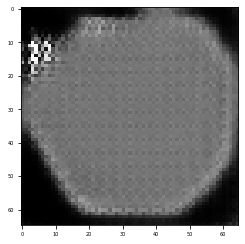

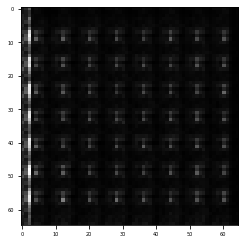

[Epoch 203/20000] [G_A loss: 4.393855] [D_B loss: 0.284934]

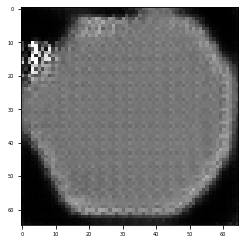

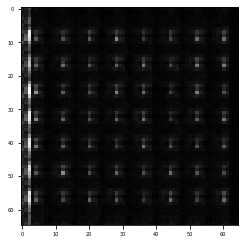

[Epoch 204/20000] [G_A loss: 4.367811] [D_B loss: 0.280889]

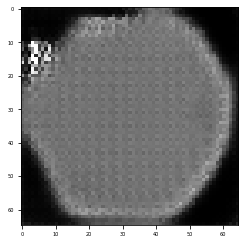

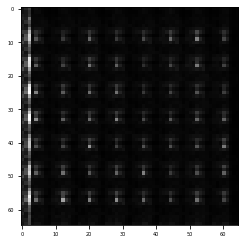

[Epoch 205/20000] [G_A loss: 4.393283] [D_B loss: 0.256556]

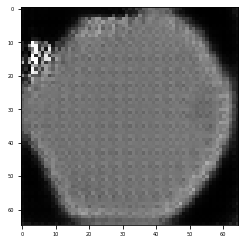

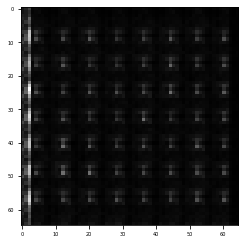

[Epoch 206/20000] [G_A loss: 4.381370] [D_B loss: 0.237599]

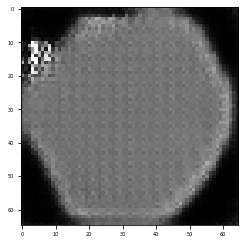

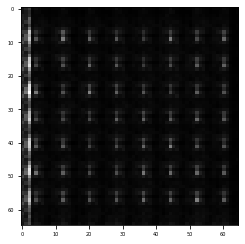

[Epoch 207/20000] [G_A loss: 4.396995] [D_B loss: 0.232481]

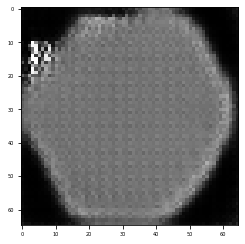

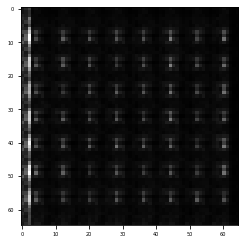

[Epoch 208/20000] [G_A loss: 4.344225] [D_B loss: 0.231412]

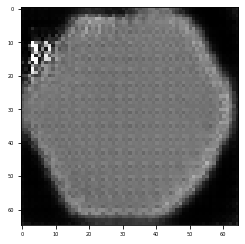

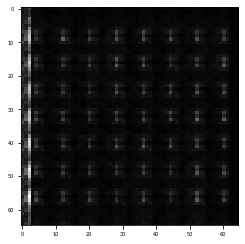

[Epoch 209/20000] [G_A loss: 4.358786] [D_B loss: 0.231169]

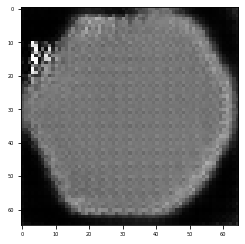

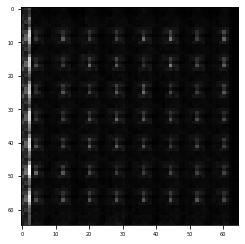

[Epoch 210/20000] [G_A loss: 4.329795] [D_B loss: 0.229761]

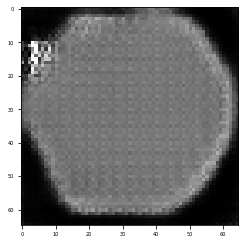

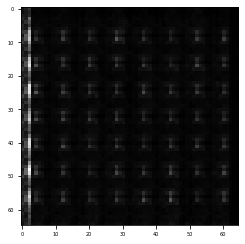

[Epoch 211/20000] [G_A loss: 4.365553] [D_B loss: 0.229097]

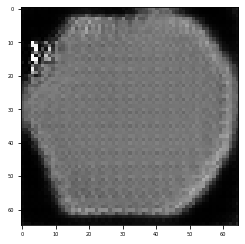

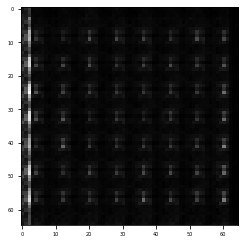

[Epoch 212/20000] [G_A loss: 4.412752] [D_B loss: 0.229457]

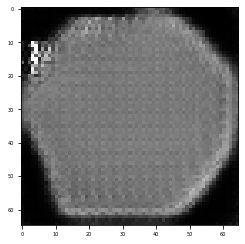

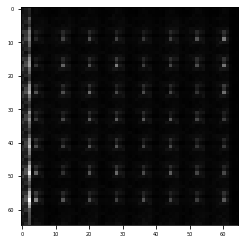

[Epoch 213/20000] [G_A loss: 4.421828] [D_B loss: 0.232416]

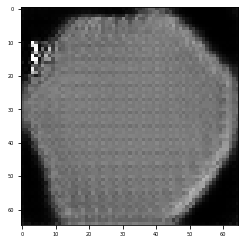

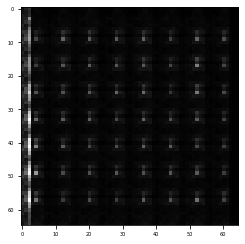

[Epoch 214/20000] [G_A loss: 4.397776] [D_B loss: 0.228022]

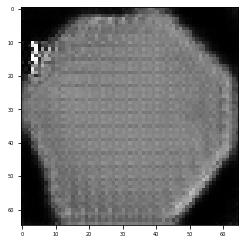

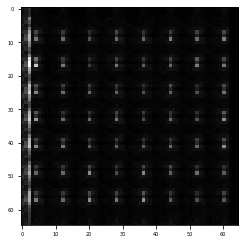

[Epoch 215/20000] [G_A loss: 4.395422] [D_B loss: 0.225014]

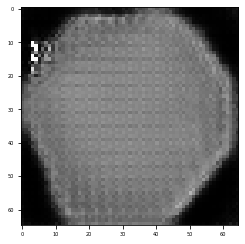

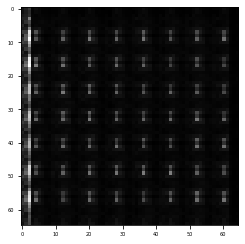

[Epoch 216/20000] [G_A loss: 4.334820] [D_B loss: 0.224486]

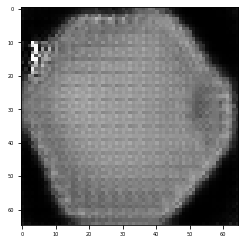

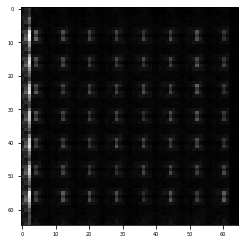

[Epoch 217/20000] [G_A loss: 4.401021] [D_B loss: 0.227178]

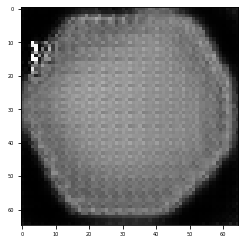

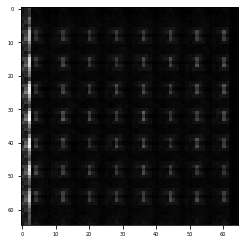

[Epoch 218/20000] [G_A loss: 4.370790] [D_B loss: 0.220572]

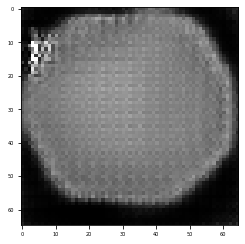

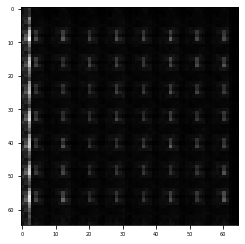

[Epoch 219/20000] [G_A loss: 4.381759] [D_B loss: 0.242239]

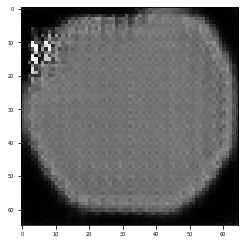

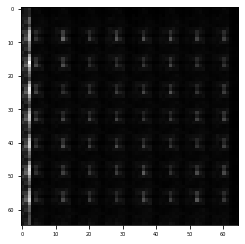

[Epoch 220/20000] [G_A loss: 4.337321] [D_B loss: 0.264225]

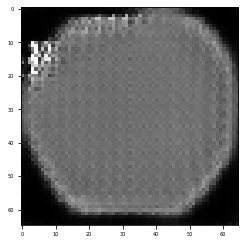

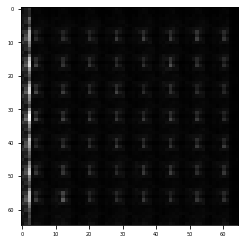

[Epoch 221/20000] [G_A loss: 4.362213] [D_B loss: 0.300960]

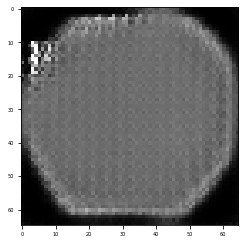

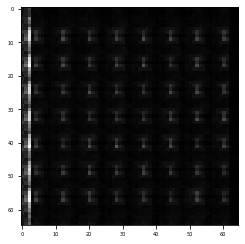

[Epoch 222/20000] [G_A loss: 4.379212] [D_B loss: 0.317079]

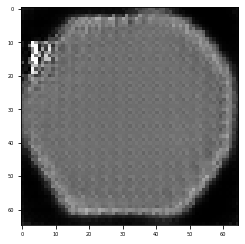

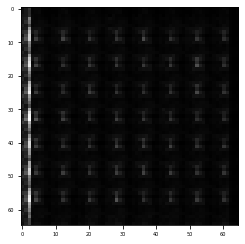

[Epoch 223/20000] [G_A loss: 4.403856] [D_B loss: 0.304269]

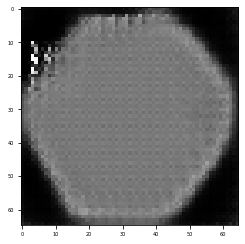

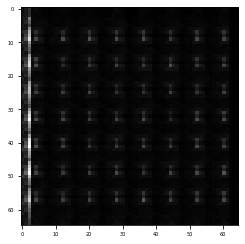

[Epoch 224/20000] [G_A loss: 4.431672] [D_B loss: 0.290364]

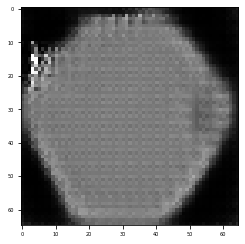

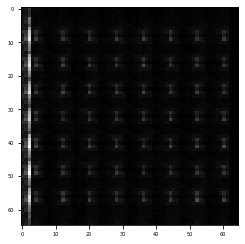

[Epoch 225/20000] [G_A loss: 4.288552] [D_B loss: 0.297750]

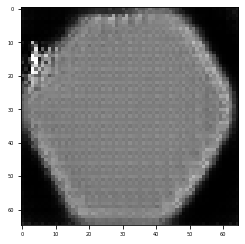

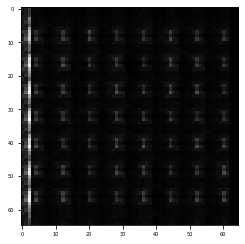

[Epoch 226/20000] [G_A loss: 4.422910] [D_B loss: 0.293817]

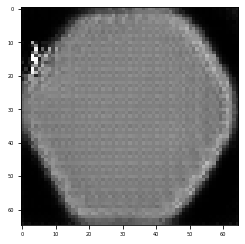

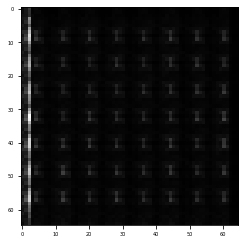

[Epoch 227/20000] [G_A loss: 4.272100] [D_B loss: 0.262910]

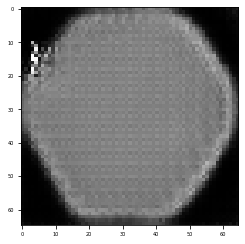

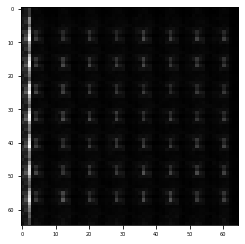

[Epoch 228/20000] [G_A loss: 4.351209] [D_B loss: 0.239736]

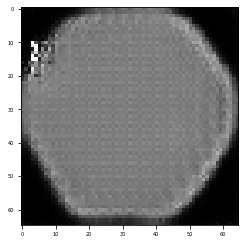

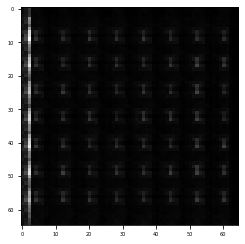

[Epoch 229/20000] [G_A loss: 4.297562] [D_B loss: 0.238296]

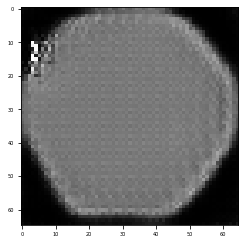

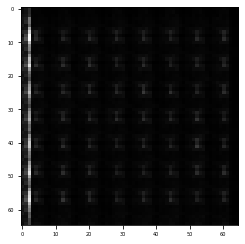

[Epoch 230/20000] [G_A loss: 4.361802] [D_B loss: 0.238137]

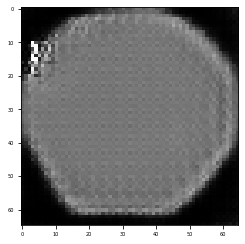

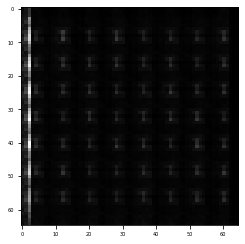

[Epoch 231/20000] [G_A loss: 4.296906] [D_B loss: 0.239175]

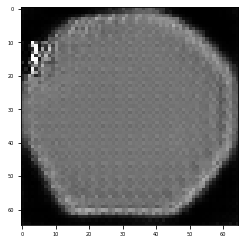

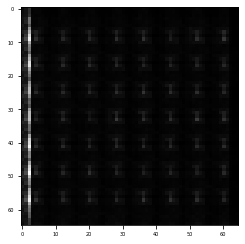

[Epoch 232/20000] [G_A loss: 4.354754] [D_B loss: 0.236944]

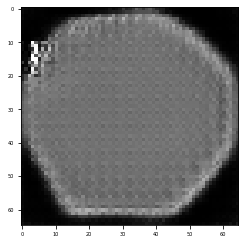

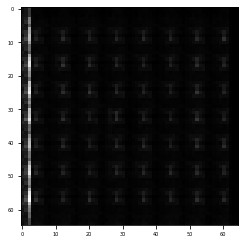

[Epoch 233/20000] [G_A loss: 4.331000] [D_B loss: 0.237796]

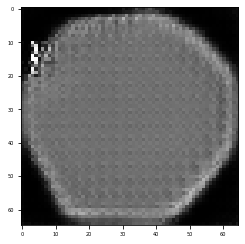

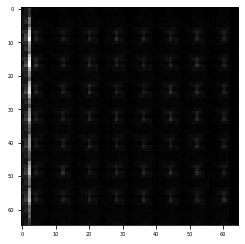

[Epoch 234/20000] [G_A loss: 4.361725] [D_B loss: 0.234683]

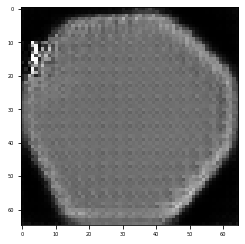

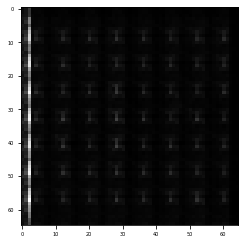

[Epoch 235/20000] [G_A loss: 4.426266] [D_B loss: 0.234012]

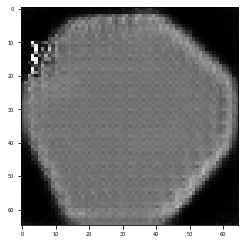

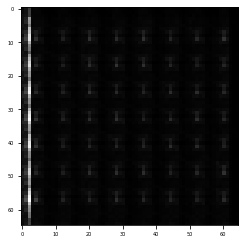

[Epoch 236/20000] [G_A loss: 4.369343] [D_B loss: 0.233042]

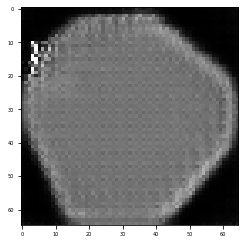

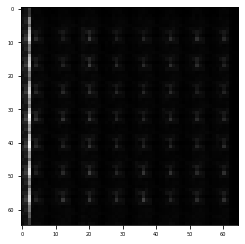

[Epoch 237/20000] [G_A loss: 4.379812] [D_B loss: 0.232231]

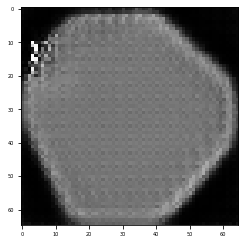

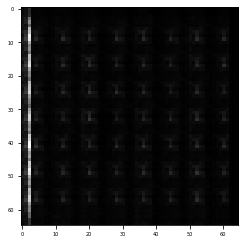

[Epoch 238/20000] [G_A loss: 4.458008] [D_B loss: 0.233281]

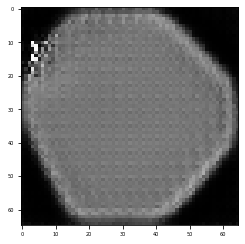

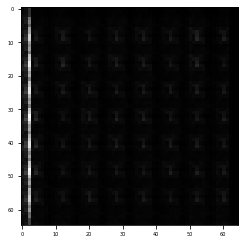

[Epoch 239/20000] [G_A loss: 4.417220] [D_B loss: 0.234626]

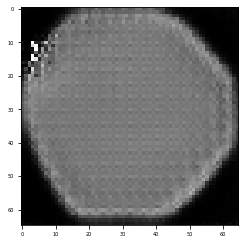

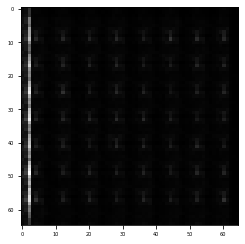

[Epoch 240/20000] [G_A loss: 4.507357] [D_B loss: 0.239951]

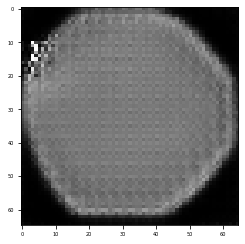

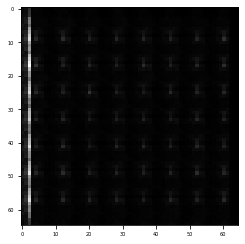

[Epoch 241/20000] [G_A loss: 4.348399] [D_B loss: 0.243720]

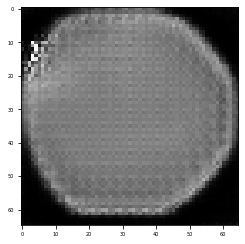

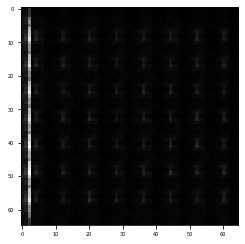

[Epoch 242/20000] [G_A loss: 4.496007] [D_B loss: 0.255618]

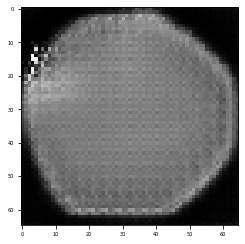

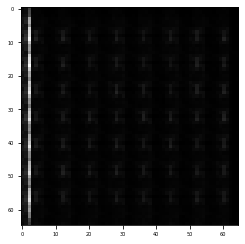

[Epoch 243/20000] [G_A loss: 4.400254] [D_B loss: 0.272130]

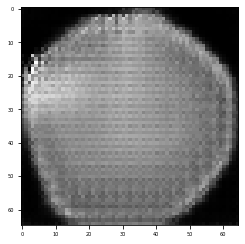

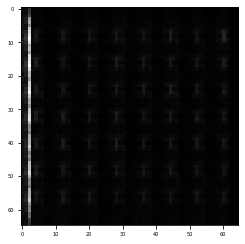

[Epoch 244/20000] [G_A loss: 4.436111] [D_B loss: 0.260034]

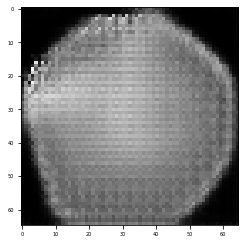

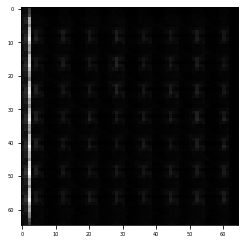

[Epoch 245/20000] [G_A loss: 4.438839] [D_B loss: 0.258441]

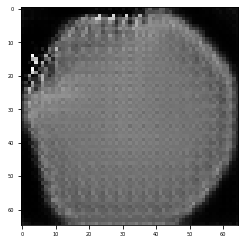

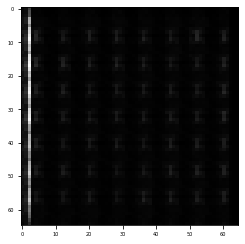

[Epoch 246/20000] [G_A loss: 4.477530] [D_B loss: 0.269448]

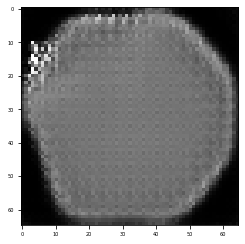

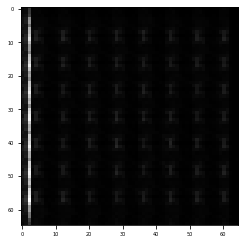

[Epoch 247/20000] [G_A loss: 4.351847] [D_B loss: 0.275267]

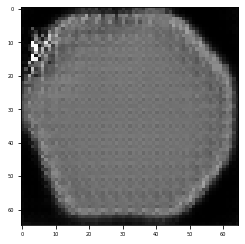

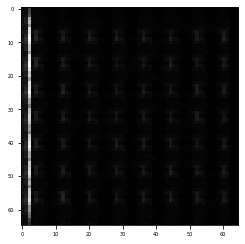

[Epoch 248/20000] [G_A loss: 4.480454] [D_B loss: 0.271306]

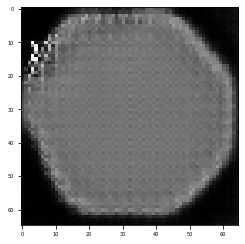

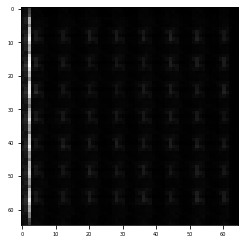

[Epoch 249/20000] [G_A loss: 4.399369] [D_B loss: 0.258676]

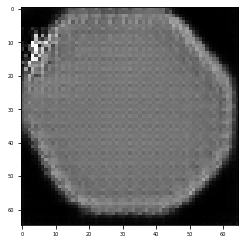

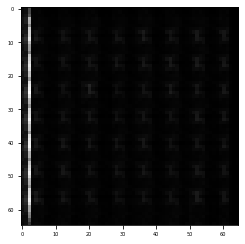

[Epoch 250/20000] [G_A loss: 4.534258] [D_B loss: 0.256387]

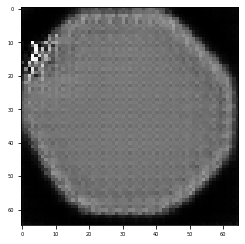

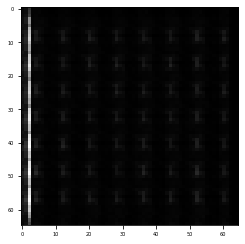

[Epoch 251/20000] [G_A loss: 4.394229] [D_B loss: 0.248119]

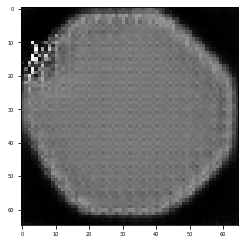

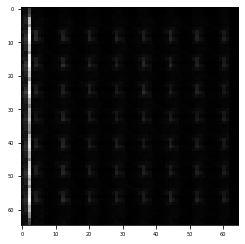

[Epoch 252/20000] [G_A loss: 4.480393] [D_B loss: 0.247806]

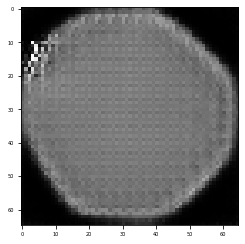

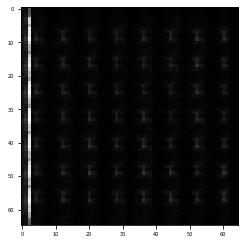

[Epoch 253/20000] [G_A loss: 4.477498] [D_B loss: 0.246589]

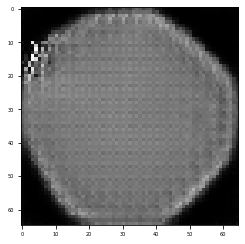

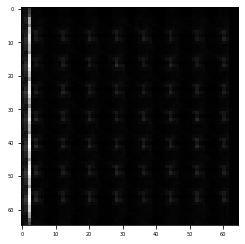

[Epoch 254/20000] [G_A loss: 4.354767] [D_B loss: 0.242973]

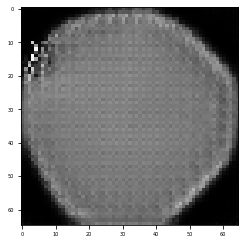

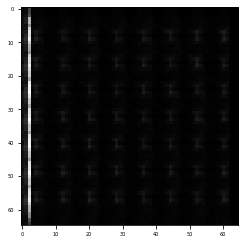

[Epoch 255/20000] [G_A loss: 4.631933] [D_B loss: 0.240816]

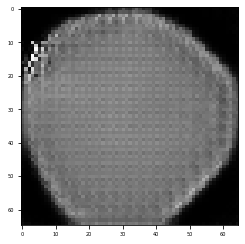

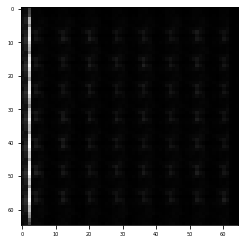

[Epoch 256/20000] [G_A loss: 4.256883] [D_B loss: 0.237834]

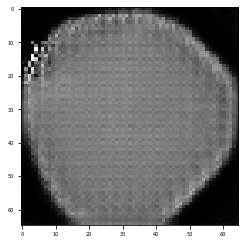

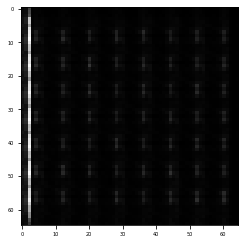

[Epoch 257/20000] [G_A loss: 4.650708] [D_B loss: 0.237392]

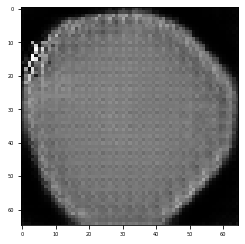

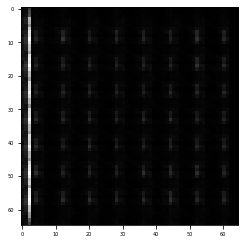

[Epoch 258/20000] [G_A loss: 4.307893] [D_B loss: 0.235263]

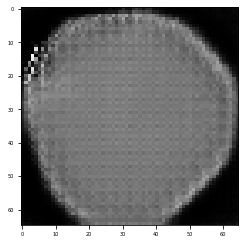

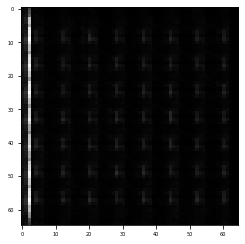

[Epoch 259/20000] [G_A loss: 4.467913] [D_B loss: 0.236388]

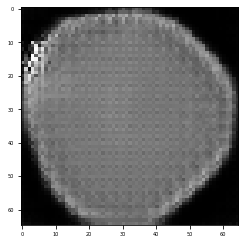

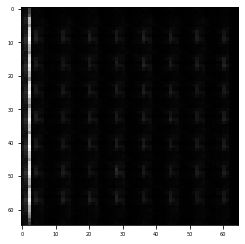

[Epoch 260/20000] [G_A loss: 4.432097] [D_B loss: 0.240885]

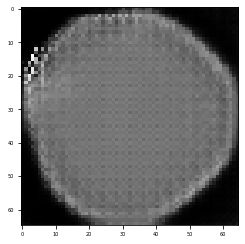

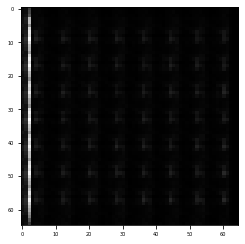

[Epoch 261/20000] [G_A loss: 4.512683] [D_B loss: 0.252804]

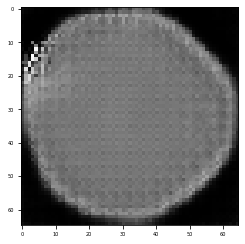

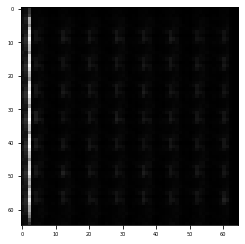

[Epoch 262/20000] [G_A loss: 4.290586] [D_B loss: 0.265582]

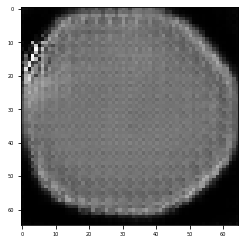

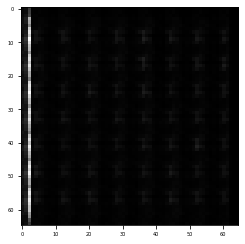

[Epoch 263/20000] [G_A loss: 4.626668] [D_B loss: 0.274785]

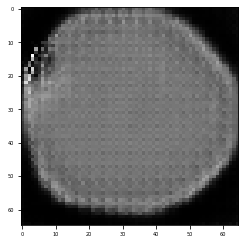

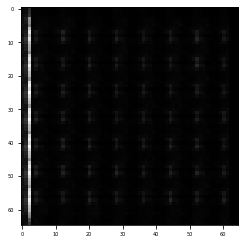

[Epoch 264/20000] [G_A loss: 4.289350] [D_B loss: 0.271048]

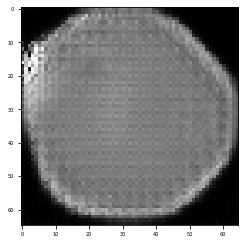

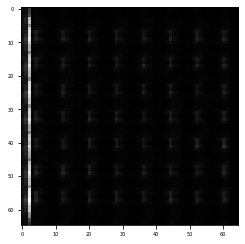

[Epoch 265/20000] [G_A loss: 4.438178] [D_B loss: 0.263812]

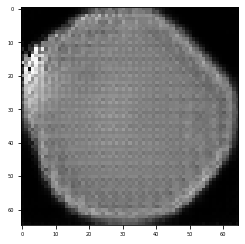

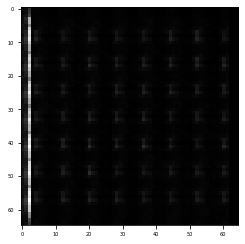

[Epoch 266/20000] [G_A loss: 4.403798] [D_B loss: 0.253209]

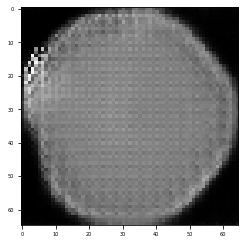

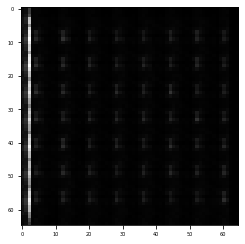

[Epoch 267/20000] [G_A loss: 4.464490] [D_B loss: 0.244148]

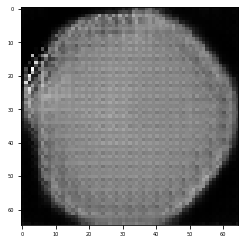

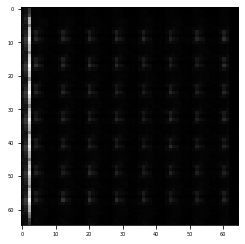

[Epoch 268/20000] [G_A loss: 4.379439] [D_B loss: 0.241726]

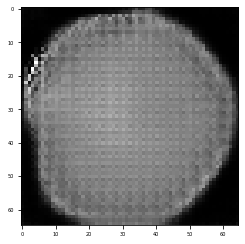

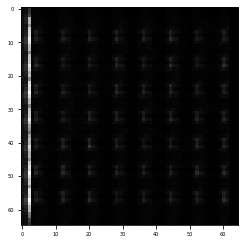

[Epoch 269/20000] [G_A loss: 4.472250] [D_B loss: 0.240342]

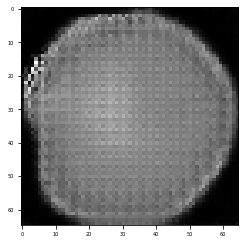

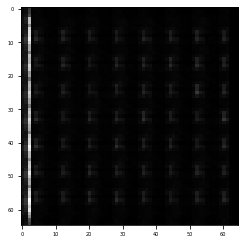

[Epoch 270/20000] [G_A loss: 4.437407] [D_B loss: 0.243565]

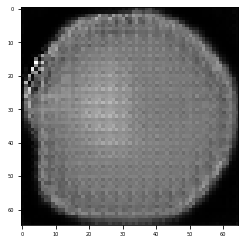

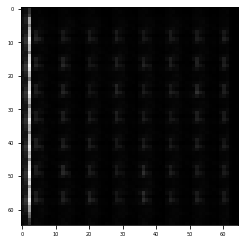

[Epoch 271/20000] [G_A loss: 4.366518] [D_B loss: 0.243675]

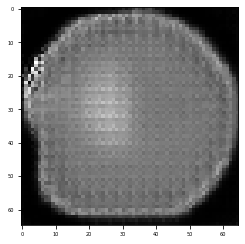

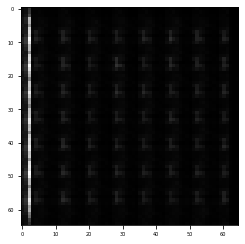

[Epoch 272/20000] [G_A loss: 4.514490] [D_B loss: 0.247503]

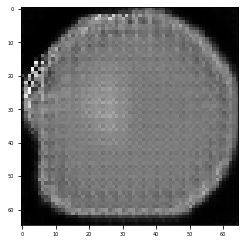

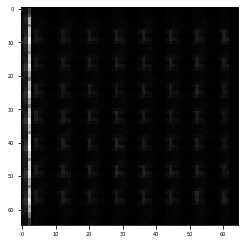

[Epoch 273/20000] [G_A loss: 4.347090] [D_B loss: 0.249606]

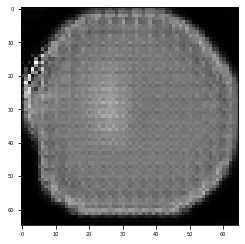

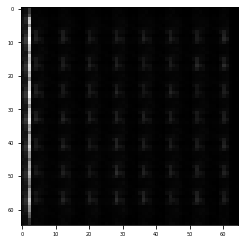

[Epoch 274/20000] [G_A loss: 4.515550] [D_B loss: 0.248823]

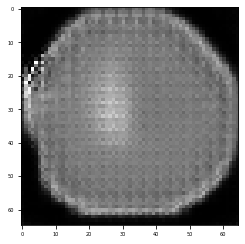

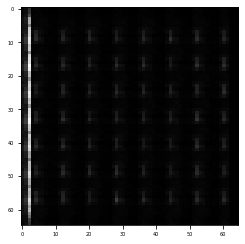

[Epoch 275/20000] [G_A loss: 4.342666] [D_B loss: 0.248014]

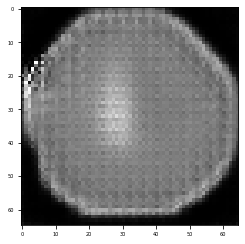

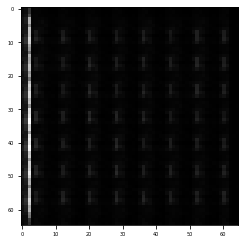

[Epoch 276/20000] [G_A loss: 4.515633] [D_B loss: 0.252046]

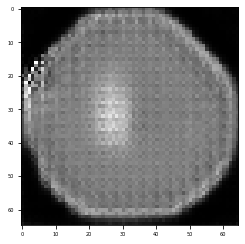

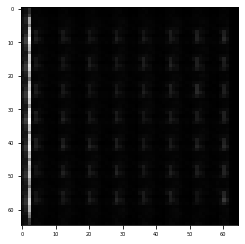

[Epoch 277/20000] [G_A loss: 4.356455] [D_B loss: 0.255598]

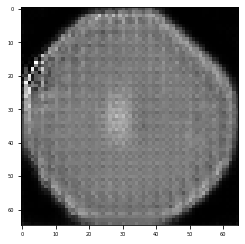

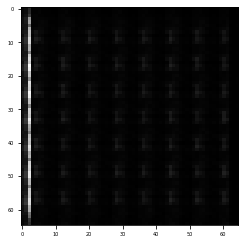

[Epoch 278/20000] [G_A loss: 4.457133] [D_B loss: 0.249097]

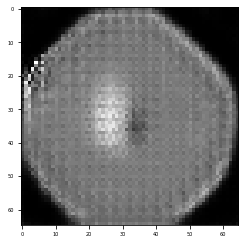

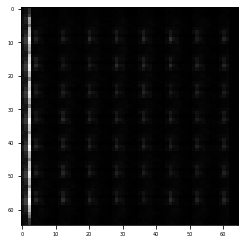

[Epoch 279/20000] [G_A loss: 4.333076] [D_B loss: 0.250499]

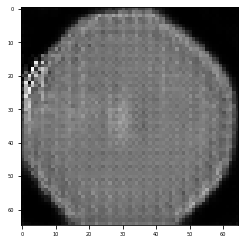

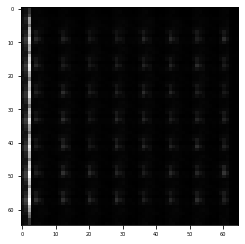

[Epoch 280/20000] [G_A loss: 4.496758] [D_B loss: 0.241175]

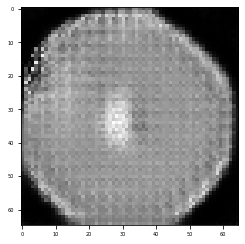

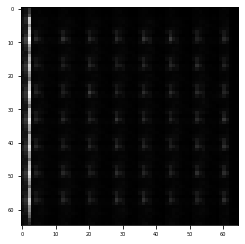

[Epoch 281/20000] [G_A loss: 4.295760] [D_B loss: 0.237741]

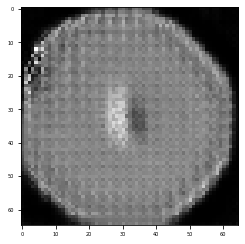

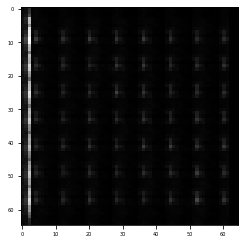

[Epoch 282/20000] [G_A loss: 4.474391] [D_B loss: 0.244121]

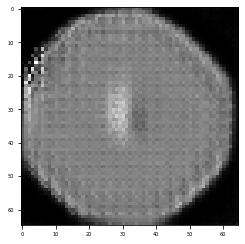

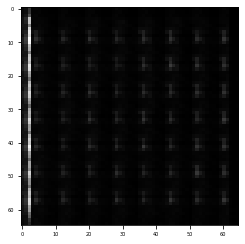

[Epoch 283/20000] [G_A loss: 4.390479] [D_B loss: 0.248696]

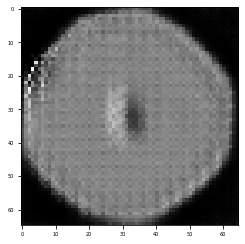

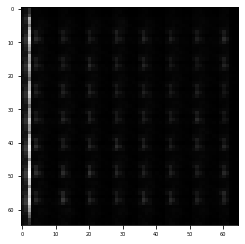

[Epoch 284/20000] [G_A loss: 4.429849] [D_B loss: 0.226892]

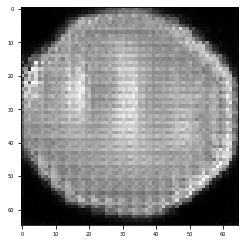

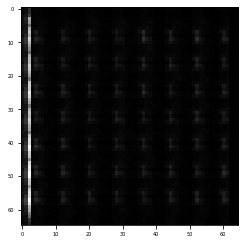

[Epoch 285/20000] [G_A loss: 4.417598] [D_B loss: 0.243805]

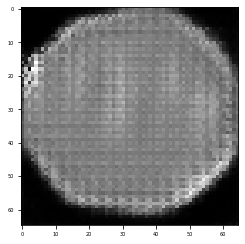

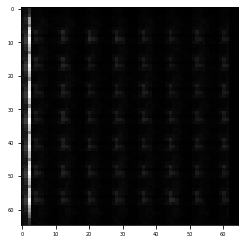

[Epoch 286/20000] [G_A loss: 4.365343] [D_B loss: 0.274055]

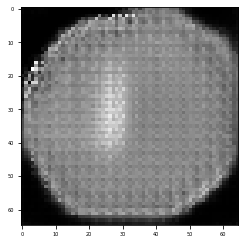

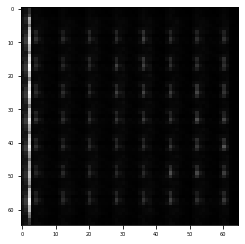

[Epoch 287/20000] [G_A loss: 4.421091] [D_B loss: 0.321343]

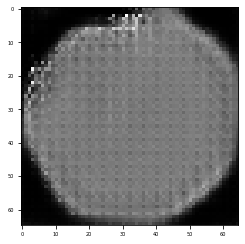

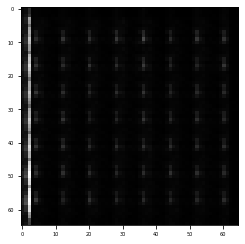

[Epoch 288/20000] [G_A loss: 4.398925] [D_B loss: 0.349707]

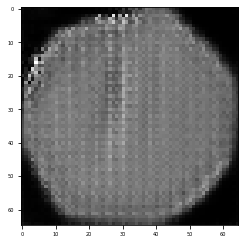

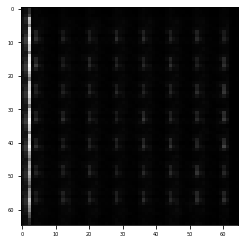

[Epoch 289/20000] [G_A loss: 4.308602] [D_B loss: 0.340815]

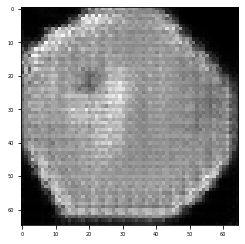

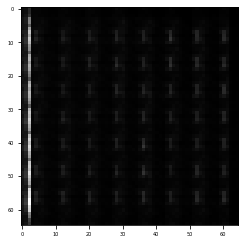

[Epoch 290/20000] [G_A loss: 4.385456] [D_B loss: 0.272394]

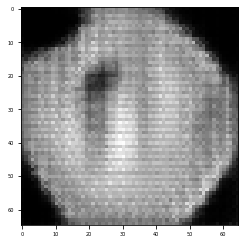

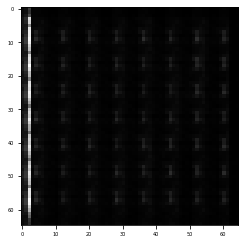

[Epoch 291/20000] [G_A loss: 4.461226] [D_B loss: 0.213234]

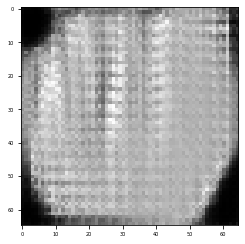

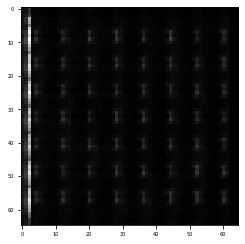

[Epoch 292/20000] [G_A loss: 4.184255] [D_B loss: 0.222258]

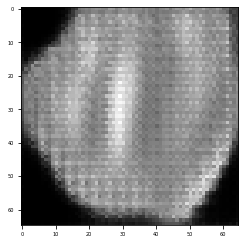

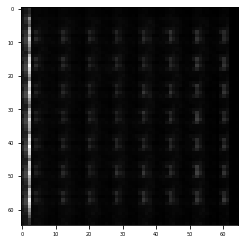

[Epoch 293/20000] [G_A loss: 4.562395] [D_B loss: 0.221090]

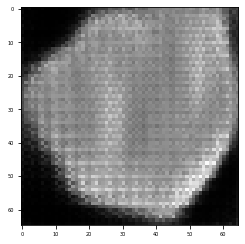

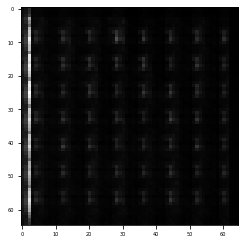

KeyboardInterrupt: ignored

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import random
import pickle


cuda = torch.cuda.is_available()

'''
Encoder
'''
Encoder = EncoderNet(input_shape=(2,1,64,64))
'''
Decoder
'''
Decoder = DecoderNet(input_shape=(1,512,64,64))

'''
Discriminator
'''
discriminator = Discriminator((1,64,64))
discriminator_aux = Discriminator_aux((1,64,64))

'''
Generator
'''
G_A=GeneratorResNet(skip=False)

if cuda:
    Encoder = Encoder.cuda()
    Decoder = Decoder.cuda()
    discriminator = discriminator.cuda()
    discriminator_aux=discriminator_aux.cuda()
    G_A=G_A.cuda()



opt={"lr":0.0002,"b1":0.5, "b2":0.999, "epoch":0, "n_epochs":20000, "decay_epoch":5, "lambda_cyc":10.0, "lambda_id":5.0}


# optimizer_G = torch.optim.Adam(G_A.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_E = torch.optim.Adam(Encoder.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_D = torch.optim.Adam(Decoder.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_G = torch.optim.Adam(itertools.chain(G_A.parameters(), Encoder.parameters(), Decoder.parameters()), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D_A = torch.optim.Adam(discriminator_aux.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D_B = torch.optim.Adam(discriminator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))


Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
G_A.train()
discriminator.train()
Encoder.train()
Decoder.train()
discriminator_aux.train()

'''
Training loop starts
'''
for epoch in range(opt["n_epochs"]):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
       
        if (i==1): # trying to overfit on single image
          i=0
          break
        
        with torch.autograd.set_detect_anomaly(True):
          

          real_A = Variable(batch[0]["input"].type(Tensor)) # mri
          real_B = Variable(batch[1]["input"].type(Tensor)) # ct

          '''
          Normalize data b/w -1,1 range
          '''
          real_A = (2*((real_A - torch.min(real_A))/(torch.max(real_A)-torch.min(real_A))))-1
          real_B = (2*((real_B - torch.min(real_B))/(torch.max(real_B)-torch.min(real_B))))-1

          ################ Computing GAN Losses
          '''
          Optimizing G_A network
          (real_A -> fake_B)
          '''

          optimizer_G.zero_grad()

          fake_imgs_b = G_A(real_A)

          '''
          D_B Discriminator
          '''
          prob_fake_b_is_real = discriminator(fake_imgs_b)
          lsgan_loss_b = lsgan_loss_generator(prob_fake_b_is_real)

          

          '''
          Optimizing the G_B network E/D 
          (real_B -> fake_A)
          '''

          latent_real_b, latent_real_b_II = Encoder(real_B)
          fake_imgs_a = Decoder(latent_real_b, real_B)

          '''
          D_A discriminator
          '''
          prob_fake_a_is_real, prob_fake_a_aux_is_real = discriminator_aux(fake_imgs_a)
          lsgan_loss_a = lsgan_loss_generator(prob_fake_a_is_real)

          '''
          Not adding lsgan_loss_a and lsgan_loss_b ?
          '''

          ##################### GAN Cycle loss

          latent_fake_b, latent_fake_b_II = Encoder(fake_imgs_b)
          cycle_imgs_a = Decoder(latent_fake_b, fake_imgs_b)
          
          cycle_consistency_loss_a = LAMBDA_A * cycle_consistency_loss(real_images=real_A, generated_images=cycle_imgs_a)
          
          cycle_imgs_b = G_A(fake_imgs_a)
          cycle_consistency_loss_b = LAMBDA_B * cycle_consistency_loss(real_images=real_B, generated_images=cycle_imgs_b)

          
          ####################### Total Generator losses (not adding g_loss_a and g_loss_b ?)
          '''
          final G_A loss 
          '''
          g_loss_a = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_b
          '''
          final E/D loss
          '''
          g_loss_b = cycle_consistency_loss_b + cycle_consistency_loss_a + lsgan_loss_a

          '''
          backward
          '''
          g_loss_a.backward(retain_graph=True)
          g_loss_b.backward(retain_graph=True)
          optimizer_G.step()

          ############### Computing Discriminator losses
          ############### Computing D_A loss

          optimizer_D_B.zero_grad()
          '''
          Optimizing the D_B network
          '''
          
          fake_pool_b=fake_imgs_b
          fake_pool_b=fake_pool_b.detach()
          prob_real_b_is_real = discriminator(real_B)
          prob_fake_pool_b_is_real = discriminator(fake_pool_b)

          d_loss_b = lsgan_loss_discriminator(prob_real_b_is_real, prob_fake_pool_b_is_real)

          '''
          backward
          '''
          d_loss_b.backward()
          optimizer_D_B.step()

          ############### Computing D_B loss
          '''
          Optimizing the D_A network
          '''

          optimizer_D_A.zero_grad()
          
          fake_pool_a = fake_imgs_a
          fake_pool_a=fake_pool_a.detach()
          prob_real_a_is_real, prob_real_a_aux = discriminator_aux(real_A)
          prob_fake_pool_a_is_real, prob_fake_pool_a_aux_is_real = discriminator_aux(fake_pool_a)

          d_loss_a = lsgan_loss_discriminator(
              prob_real_a_is_real,
              prob_fake_pool_a_is_real,
          )

          '''
          ???? 
          '''
          cycle_imgs_a=cycle_imgs_a.detach()
          prob_cycle_a_is_real, prob_cycle_a_aux_is_real = discriminator_aux(cycle_imgs_a)

          d_loss_a_aux = lsgan_loss_discriminator(
              prob_cycle_a_aux_is_real,
              prob_fake_pool_a_aux_is_real,
          )

          d_loss_a = d_loss_a + d_loss_a_aux

          '''
          backward
          '''
          d_loss_a.backward()
          optimizer_D_A.step()

          # sys.stdout.write(
          #     "[Epoch %d/%d] [Batch %d/%d] [D_A loss: %f] [D_B loss: %f] [G_A loss: %f] [G_B loss: %f]\n"
          #     % (
          #         epoch,
          #         opt["n_epochs"],
          #         i,
          #         len(dataloader),
          #         d_loss_a.item(),
          #         d_loss_b.item(),
          #         g_loss_a.item(),
          #         g_loss_b.item(),
          #     )
          # )

          '''
          Putting assertions to make sure gradients flow
          '''
          for param in list(discriminator.parameters()):
            assert param.grad is not None

          for param in list(G_A.parameters()):
            assert param.grad is not None

          for param in list(discriminator_aux.parameters()):
            assert param.grad is not None

          for param in list(Encoder.parameters()):
            assert param.grad is not None

          for param in list(Decoder.parameters()):
            assert param.grad is not None

          sys.stdout.write(
              "\r[Epoch %d/%d] [G_A loss: %f] [D_B loss: %f]"
              % (
                  epoch,
                  opt["n_epochs"],
                  g_loss_b.item(),
                  d_loss_b.item()
              )
          )
          vis(fake_imgs_b)
          vis(cycle_imgs_a)
        if epoch%1000==0:
          with open('fakeb'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(fake_imgs_b, f)
          with open('fakea'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(fake_imgs_a, f)


In [ ]:
with open('fakebfinal.pickle', 'wb') as f:
  pickle.dump(fake_imgs_b, f)
with open('fakeafinal.pickle', 'wb') as f:
  pickle.dump(fake_imgs_a, f)

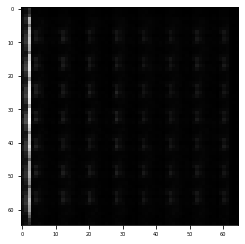

In [ ]:
# vis(fake_imgs_a)

In [ ]:
# '''
# Visualizing generator outputs
# '''
# plt.imshow(cycle_imgs_a.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(fake_imgs_b.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(real_A.detach().cpu().squeeze(),cmap='gray')
# plt.show()